<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/main/tutorials/W2D4_GenerativeModels/student/W2D4_Tutorial1.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D4_GenerativeModels/student/W2D4_Tutorial1.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 1: Variational Autoencoders (VAEs)

**Week 2, Day 4: Generative Models**

**By Neuromatch Academy**

__Content creators:__ Saeed Salehi, Spiros Chavlis, Vikash Gilja

__Content reviewers:__ Diptodip Deb, Kelson Shilling-Scrivo

__Content editor:__ Charles J Edelson, Spiros Chavlis

__Production editors:__ Saeed Salehi, Gagana B, Spiros Chavlis


<br>

*Inspired from UPenn course*:
__Instructor:__ Konrad Kording, __Original Content creators:__ Richard Lange, Arash Ash

---
# Tutorial Objectives
In the first tutorial of the *Generative Models* day, we are going to

- Think about unsupervised learning / Generative Models and get a bird's eye view of why it is useful
- Build intuition about latent variables
- See the connection between AutoEncoders and PCA
- Start thinking about neural networks as generative models by contrasting AutoEncoders and Variational AutoEncoders

In [1]:
# @markdown
from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()
with out:
    print(f"If you want to download the slides: https://osf.io/download/rd7ng/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/rd7ng/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

Output()

---
# Setup

##  Install dependencies


 #### Please ignore *errors* and/or *warnings* during installation.


In [2]:
# @title Install dependencies
# @markdown #### Please ignore *errors* and/or *warnings* during installation.
!pip install pytorch-pretrained-biggan --quiet
!pip install Pillow libsixel-python --quiet

ERROR: Could not find a version that satisfies the requirement pytorch-pretrained-biggan (from versions: none)
ERROR: No matching distribution found for pytorch-pretrained-biggan
ERROR: Could not find a version that satisfies the requirement libsixel-python (from versions: none)
ERROR: No matching distribution found for libsixel-python


##  Install and import feedback gadget


In [3]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W2D4_T1"

In [5]:
# Imports
import torch
import random

import numpy as np
import matplotlib.pylab as plt

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms

from tqdm.notebook import tqdm, trange


from pytorch_pretrained_biggan import one_hot_from_names

ModuleNotFoundError: No module named 'pytorch_pretrained_biggan'

##  Figure settings


In [6]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, HBox, Layout, VBox
from ipywidgets import interactive_output, Dropdown

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

##  Helper functions


In [7]:
# @title Helper functions


def image_moments(image_batches, n_batches=None):
  """
  Compute mean and covariance of all pixels
  from batches of images

  Args:
    Image_batches: tuple
      Image batches
    n_batches: int
      Number of Batch size

  Returns:
    m1: float
      Mean of all pixels
    cov: float
      Covariance of all pixels
  """
  m1, m2 = torch.zeros((), device=DEVICE), torch.zeros((), device=DEVICE)
  n = 0
  for im in tqdm(image_batches, total=n_batches, leave=False,
                 desc='Computing pixel mean and covariance...'):
    im = im.to(DEVICE)
    b = im.size()[0]
    im = im.view(b, -1)
    m1 = m1 + im.sum(dim=0)
    m2 = m2 + (im.view(b,-1,1) * im.view(b,1,-1)).sum(dim=0)
    n += b
  m1, m2 = m1/n, m2/n
  cov = m2 - m1.view(-1,1)*m1.view(1,-1)
  return m1.cpu(), cov.cpu()


def interpolate(A, B, num_interps):
  """
  Function to interpolate between images.
  It does this by linearly interpolating between the
  probability of each category you select and linearly
  interpolating between the latent vector values.

  Args:
    A: list
      List of categories
    B: list
      List of categories
    num_interps: int
      Quantity of pixel grids

  Returns:
    Interpolated np.ndarray
  """
  if A.shape != B.shape:
    raise ValueError('A and B must have the same shape to interpolate.')
  alphas = np.linspace(0, 1, num_interps)
  return np.array([(1-a)*A + a*B for a in alphas])


def kl_q_p(zs, phi):
  """
  Given [b,n,k] samples of z drawn
  from q, compute estimate of KL(q||p).
  phi must be size [b,k+1]
  This uses mu_p = 0 and sigma_p = 1,
  which simplifies the log(p(zs)) term to
  just -1/2*(zs**2)

  Args:
    zs: list
      Samples
    phi: list
      Relative entropy

  Returns:
    Size of log_q and log_p is [b,n,k].
    Sum along [k] but mean along [b,n]
  """
  b, n, k = zs.size()
  mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
  log_p = -0.5*(zs**2)
  log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
  # Size of log_q and log_p is [b,n,k].
  # Sum along [k] but mean along [b,n]
  return (log_q - log_p).sum(dim=2).mean(dim=(0,1))


def log_p_x(x, mu_xs, sig_x):
  """
  Given [batch, ...] input x and
  [batch, n, ...] reconstructions, compute
  pixel-wise log Gaussian probability
  Sum over pixel dimensions, but mean over batch
  and samples.

  Args:
    x: np.ndarray
      Input Data
    mu_xs: np.ndarray
      Log of mean of samples
    sig_x: np.ndarray
      Log of standard deviation

  Returns:
    Mean over batch and samples.
  """
  b, n = mu_xs.size()[:2]
  # Flatten out pixels and add a singleton
  # dimension [1] so that x will be
  # implicitly expanded when combined with mu_xs
  x = x.reshape(b, 1, -1)
  _, _, p = x.size()
  squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

  # Size of squared_error is [b,n,p]. log prob is
  # by definition sum over [p].
  # Expected value requires mean over [n].
  # Handling different size batches
  # requires mean over [b].
  return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))


def pca_encoder_decoder(mu, cov, k):
  """
  Compute encoder and decoder matrices
  for PCA dimensionality reduction

  Args:
    mu: np.ndarray
      Mean
    cov: float
      Covariance
    k: int
      Dimensionality

  Returns:
    Nothing
  """
  mu = mu.view(1,-1)
  u, s, v = torch.svd_lowrank(cov, q=k)
  W_encode = v / torch.sqrt(s)
  W_decode = u * torch.sqrt(s)

  def pca_encode(x):
    """
    Encoder: Subtract mean image and
    project onto top K eigenvectors of
    the data covariance

    Args:
      x: torch.tensor
        Input data

    Returns:
      PCA Encoding
    """
    return (x.view(-1,mu.numel()) - mu) @ W_encode

  def pca_decode(h):
    """
    Decoder: un-project then add back in the mean

    Args:
      h: torch.tensor
        Hidden layer data

    Returns:
      PCA Decoding
    """
    return (h @ W_decode.T) + mu

  return pca_encode, pca_decode


def cout(x, layer):
  """
  Unnecessarily complicated but complete way to
  calculate the output depth, height
  and width size for a Conv2D layer

  Args:
    x: tuple
      Input size (depth, height, width)
    layer: nn.Conv2d
      The Conv2D layer

  Returns:
    Tuple of out-depth/out-height and out-width
    Output shape as given in [Ref]
    Ref:
    https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
  """
  assert isinstance(layer, nn.Conv2d)
  p = layer.padding if isinstance(layer.padding, tuple) else (layer.padding,)
  k = layer.kernel_size if isinstance(layer.kernel_size, tuple) else (layer.kernel_size,)
  d = layer.dilation if isinstance(layer.dilation, tuple) else (layer.dilation,)
  s = layer.stride if isinstance(layer.stride, tuple) else (layer.stride,)
  in_depth, in_height, in_width = x
  out_depth = layer.out_channels
  out_height = 1 + (in_height + 2 * p[0] - (k[0] - 1) * d[0] - 1) // s[0]
  out_width = 1 + (in_width + 2 * p[-1] - (k[-1] - 1) * d[-1] - 1) // s[-1]
  return (out_depth, out_height, out_width)

##  Plotting functions


In [8]:
# @title Plotting functions

def plot_gen_samples_ppca(therm1, therm2, therm_data_sim):
  """
  Plotting generated samples

  Args:
    therm1: list
      Thermometer 1
    them2: list
      Thermometer 2
    therm_data_sim: list
      Generated (simulate, draw) `n_samples` from pPCA model

  Returns:
    Nothing
  """
  plt.plot(therm1, therm2, '.', c='c', label='training data')
  plt.plot(therm_data_sim[0], therm_data_sim[1], '.', c='m', label='"generated" data')
  plt.axis('equal')
  plt.xlabel('Thermometer 1 ($^\circ$C)')
  plt.ylabel('Thermometer 2 ($^\circ$C)')
  plt.legend()
  plt.show()


def plot_linear_ae(lin_losses):
  """
  Plotting linear autoencoder

  Args:
    lin_losses: list
      Log of linear autoencoder MSE losses

  Returns:
    Nothing
  """
  plt.figure()
  plt.plot(lin_losses)
  plt.ylim([0, 2*torch.as_tensor(lin_losses).median()])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.show()


def plot_conv_ae(lin_losses, conv_losses):
  """
  Plotting convolutional autoencoder

  Args:
    lin_losses: list
      Log of linear autoencoder MSE losses
    conv_losses: list
      Log of convolutional model MSe losses

  Returns:
    Nothing
  """
  plt.figure()
  plt.plot(lin_losses)
  plt.plot(conv_losses)
  plt.legend(['Lin AE', 'Conv AE'])
  plt.xlabel('Training batch')
  plt.ylabel('MSE Loss')
  plt.ylim([0,
            2*max(torch.as_tensor(conv_losses).median(),
                  torch.as_tensor(lin_losses).median())])
  plt.show()


def plot_images(images, h=3, w=3, plt_title=''):
  """
  Helper function to plot images

  Args:
    images: torch.tensor
      Images
    h: int
      Image height
    w: int
      Image width
    plt_title: string
      Plot title

  Returns:
    Nothing
  """
  plt.figure(figsize=(h*2, w*2))
  plt.suptitle(plt_title, y=1.03)
  for i in range(h*w):
    plt.subplot(h, w, i + 1)
    plot_torch_image(images[i])
  plt.axis('off')
  plt.show()

def plot_phi(phi, num=4):
  """
  Contour plot of relative entropy across samples

  Args:
    phi: list
      Log of relative entropu changes
    num: int
      Number of interations
  """
  plt.figure(figsize=(12, 3))
  for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.scatter(zs[i, :, 0], zs[i, :, 1], marker='.')
    th = torch.linspace(0, 6.28318, 100)
    x, y = torch.cos(th), torch.sin(th)
    # Draw 2-sigma contours
    plt.plot(
        2*x*phi[i, 2].exp().item() + phi[i, 0].item(),
        2*y*phi[i, 2].exp().item() + phi[i, 1].item()
        )
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    plt.grid()
    plt.axis('equal')
  plt.suptitle('If rsample() is correct, then most but not all points should lie in the circles')
  plt.show()


def plot_torch_image(image, ax=None):
  """
  Helper function to plot torch image

  Args:
    image: torch.tensor
      Image
    ax: plt object
      If None, plt.gca()

  Returns:
    Nothing
  """
  ax = ax if ax is not None else plt.gca()
  c, h, w = image.size()
  if c==1:
    cm = 'gray'
  else:
    cm = None

  # Torch images have shape (channels, height, width)
  # but matplotlib expects
  # (height, width, channels) or just
  # (height,width) when grayscale
  im_plt = torch.clip(image.detach().cpu().permute(1,2,0).squeeze(), 0.0, 1.0)
  ax.imshow(im_plt, cmap=cm)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

##  Set random seed


 Executing `set_seed(seed=seed)` you are setting the seed


In [9]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

##  Set device (GPU or CPU). Execute `set_device()`


In [10]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [11]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


##  Download `wordnet` dataset


In [12]:
# @title Download `wordnet` dataset

"""
NLTK Download:

import nltk
nltk.download('wordnet')
"""

import os, requests, zipfile

os.environ['NLTK_DATA'] = 'nltk_data/'

fnames = ['wordnet.zip', 'omw-1.4.zip']
urls = ['https://osf.io/ekjxy/download', 'https://osf.io/kuwep/download']

for fname, url in zip(fnames, urls):
  r = requests.get(url, allow_redirects=True)

  with open(fname, 'wb') as fd:
    fd.write(r.content)

  with zipfile.ZipFile(fname, 'r') as zip_ref:
    zip_ref.extractall('nltk_data/corpora')

---
# Section 1: Generative models

*Time estimate: ~15mins*

**Please** run the cell after the video to download BigGAN (a generative model) and a few standard image datasets while the video plays.

##  Video 1: Generative Modeling


In [13]:
# @title Video 1: Generative Modeling
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '5EEx0sdyR_U'), ('Bilibili', 'BV1Vy4y1j7cN')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

##  Submit your feedback


In [14]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Generative_Modeling_Video")

 Download BigGAN (a generative model) and a few standard image datasets


In [15]:
# @markdown Download BigGAN (a generative model) and a few standard image datasets

## Initially was downloaded directly
# biggan_model = BigGAN.from_pretrained('biggan-deep-256')

url = "https://osf.io/3yvhw/download"
fname = "biggan_deep_256"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fd:
  fd.write(r.content)

biggan_model = torch.load(fname)

ModuleNotFoundError: No module named 'pytorch_pretrained_biggan'

## Section 1.1: Generating Images from BigGAN

To demonstrate the power of generative models, we are giving you a sneak peek of a fully trained generative model called BigGAN. You’ll see it again (with more background under your belt) later today. For now, let’s just focus on BigGAN as a generative model. Specifically, BigGAN is a class conditional generative model for $128 \times 128$ images. The classes are based on categorical labels that describe the images and images are generated based upon a vector ($z$ from the video lecture) and the probability that the image comes from a specific discrete category.

For now, don’t worry about the specifics of the model other than the fact that it generates images based on the vector and the category label.


### Interactive Demo 1.1: BigGAN Generator


To explore the space of generated images, we’ve provided you with a widget that allows you to select a category label, generate four different z vectors, and view generated images based on those z vectors. The z vector is a 128-D, which may seem high dimensional, but is much lower-dimensional than a $128 \times 128$ image!

There is one additional slider option below: the z vector is being generated from a truncated normal distribution, where you are choosing the truncation value. Essentially, you are controlling the magnitude of the vector. **You don't need to worry about the details for now though, we're just making a conceptual point here and you don't need to know the ins and outs of truncation values or z vectors.**

Just know that each time you change the category or truncation value slider, 4 different z vectors are generated, resulting in 4 different images



 BigGAN Image Generator (the updates may take a few seconds, please be patient)


In [ ]:
# @markdown BigGAN Image Generator (the updates may take a few seconds, please be patient)

# category = 'German shepherd' # @param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
# z_magnitude = .1 # @param {type:"slider", min:0, max:1, step:.1}


from scipy.stats import truncnorm
def truncated_noise_sample(batch_size=1, dim_z=128, truncation=1., seed=None):
    """ Create a truncated noise vector.
        Params:
            batch_size: batch size.
            dim_z: dimension of z
            truncation: truncation value to use
            seed: seed for the random generator
        Output:
            array of shape (batch_size, dim_z)
    """
    state = None if seed is None else np.random.RandomState(seed)
    values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state).astype(np.float32)
    return truncation * values


def sample_from_biggan(category, z_magnitude):
  """
  Sample from BigGAN Image Generator

  Args:
    category: string
      Category
    z_magnitude: int
      Magnitude of variation vector

  Returns:
    Nothing
  """

  truncation = z_magnitude
  z = truncated_noise_sample(truncation=truncation, batch_size=4)
  y = one_hot_from_names(category, batch_size=4)

  z = torch.from_numpy(z)
  z = z.float()
  y = torch.from_numpy(y)

  # Move to GPU
  z = z.to(device=set_device())
  y = y.to(device=set_device())
  biggan_model.to(device=set_device())


  with torch.no_grad():
    output = biggan_model(z, y, truncation)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer,
  # resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to [0, 1]
  # range.
  # Clipping is only in case of numerical instability
  # problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)

  fig, axes = plt.subplots(2, 2)
  axes = axes.flatten()
  for im in range(4):

    axes[im].imshow(output[im].squeeze().moveaxis(0,-1))
    axes[im].axis('off')

z_slider = FloatSlider(min=.1, max=1, step=.1, value=0.1,
                     continuous_update=False,
                     description='Truncation Value',
                     style = {'description_width': '100px'},
                     layout=Layout(width='440px'))

category_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
             value="German shepherd",
             description="Category: ")

widgets_ui = VBox([category_dropdown, z_slider])

widgets_out = interactive_output(sample_from_biggan,
                                 {
                                  'z_magnitude': z_slider,
                                  'category': category_dropdown
                                  }
                                 )

display(widgets_ui, widgets_out)

### Think! 1.1: Generated images

How do the generated images look? Do they look realistic or obviously fake to you?

As you increase the truncation value, what do you note about the generated images and the relationship between them?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_f833b825.py)



####  Submit your feedback


In [16]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Generated_Images_Discussion")

## Section 1.2: Interpolating Images with BigGAN
This next widget allows you to interpolate between two generated images. It does this by linearly interpolating between the probability of each category you select and linearly interpolating between the latent vector values.

### Interactive Demo 1.2: BigGAN Interpolation

 BigGAN Interpolation Widget (the updates may take a few seconds)


In [17]:
# @markdown BigGAN Interpolation Widget (the updates may take a few seconds)

def interpolate_biggan(category_A,
                       category_B):
  """
  Interpolation function with BigGan

  Args:
    category_A: string
      Category specification
    category_B: string
      Category specification

  Returns:
    Nothing
  """
  num_interps = 16

  # category_A = 'jellyfish' #@param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
  # z_magnitude_A = 0 #@param {type:"slider", min:-10, max:10, step:1}

  # category_B = 'German shepherd' #@param ['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee', 'acoustic guitar', 'coffee mug', 'minibus', 'monitor']
  # z_magnitude_B = 0 #@param {type:"slider", min:-10, max:10, step:1}


  def interpolate_and_shape(A, B, num_interps):
    """
    Function to interpolate and shape images.
    It does this by linearly interpolating between the
    probability of each category you select and linearly
    interpolating between the latent vector values.

    Args:
      A: list
        List of categories
      B: list
        List of categories
      num_interps: int
        Quantity of pixel grids

    Returns:
      Interpolated np.ndarray
    """
    interps = interpolate(A, B, num_interps)
    return (interps.transpose(1, 0, *range(2, len(interps.shape))).reshape(num_interps, *interps.shape[2:]))

  # unit_vector = np.ones((1, 128))/np.sqrt(128)
  # z_A = z_magnitude_A * unit_vector
  # z_B = z_magnitude_B * unit_vector
  truncation = .4
  z_A = truncated_noise_sample(truncation=truncation, batch_size=1)
  z_B = truncated_noise_sample(truncation=truncation, batch_size=1)
  y_A = one_hot_from_names(category_A, batch_size=1)
  y_B = one_hot_from_names(category_B, batch_size=1)

  z_interp = interpolate_and_shape(z_A, z_B, num_interps)
  y_interp = interpolate_and_shape(y_A, y_B, num_interps)

  # Convert to tensor
  z_interp = torch.from_numpy(z_interp)
  z_interp = z_interp.float()
  y_interp = torch.from_numpy(y_interp)

  # Move to GPU
  z_interp = z_interp.to(DEVICE)
  y_interp = y_interp.to(DEVICE)
  biggan_model.to(DEVICE)

  with torch.no_grad():
    output = biggan_model(z_interp, y_interp, 1)

  # Back to CPU
  output = output.to('cpu')

  # The output layer of BigGAN has a tanh layer,
  # resulting the range of [-1, 1] for the output image
  # Therefore, we normalize the images properly to
  # [0, 1] range.
  # Clipping is only in case of numerical instability
  # problems

  output = torch.clip(((output.detach().clone() + 1) / 2.0), 0, 1)
  output = output

  # Make grid and show generated samples
  output_grid = torchvision.utils.make_grid(output,
                                            nrow=min(4, output.shape[0]),
                                            padding=5)
  plt.axis('off');
  plt.imshow(output_grid.permute(1, 2, 0))
  plt.show()


# z_A_slider = IntSlider(min=-10, max=10, step=1, value=0,
#                        continuous_update=False, description='Z Magnitude A',
#                        layout=Layout(width='440px'),
#                        style={'description_width': 'initial'})

# z_B_slider = IntSlider(min=-10, max=10, step=1, value=0,
#                        continuous_update=False, description='Z Magntude B',
#                        layout=Layout(width='440px'),
#                        style={'description_width': 'initial'})

category_A_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
             value="German shepherd",
             description="Category A: ")

category_B_dropdown = Dropdown(
    options=['tench', 'magpie', 'jellyfish', 'German shepherd', 'bee',
             'acoustic guitar', 'coffee mug', 'minibus', 'monitor'],
             value="jellyfish",
             description="Category B: ")



widgets_ui = VBox([HBox([category_A_dropdown]),
                   HBox([category_B_dropdown])])

widgets_out = interactive_output(interpolate_biggan,
                                 {'category_A': category_A_dropdown,
                                  # 'z_magnitude_A': z_A_slider,
                                  'category_B': category_B_dropdown})
                                  # 'z_magnitude_B': z_B_slider})

display(widgets_ui, widgets_out)

Output()

####  Submit your feedback


In [18]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_BigGAN_Interpolation_Interactive_Demo")

### Think! 1.2: Interpolating samples from the same category

Try interpolating between samples from the same category, samples from similar categories, and samples from very different categories. Do you notice any trends? What does this suggest about the representations of images in the latent space?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_09759a98.py)



####  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Samples_from_the_same_category_Discussion")

---
# Section 2: Latent Variable Models

*Time estimate: ~15mins* excluding the Bonus

##  Video 2: Latent Variable Models


In [ ]:
# @title Video 2: Latent Variable Models
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '_e0nKUeBDFo'), ('Bilibili', 'BV1Db4y167Ys')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

##  Submit your feedback


In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Latent_Variable_Models_Video")

In the video, the concept of a latent variable model was introduced. We saw how PCA (principal component analysis) can be extended into a generative model with latent variables called probabilistic PCA (pPCA). For pPCA the latent variables (z in the video) are the projections onto the principal component axes.

The dimensionality of the principal components is typically set to be substantially lower-dimensional than the original data. Thus, the latent variables (the projection onto the principal component axes) are a lower-dimensional representation of the original data (dimensionality reduction!). With pPCA we can estimate the original distribution of the high dimensional data. This allows us to generate data with a distribution that “looks” more like the original data than if we were to only use PCA to generate data from the latent variables. Let’s see how that might look with a simple example.

## (Bonus) Coding Exercise 2: pPCA

Assume we have two noisy thermometers measuring the temperature of the same room. They both make noisy measurements.  The room tends to be around 25&deg;C (that's 77&deg;F), but can vary around that temperature.  If we take lots of readings from the two thermometers over time and plot the paired readings, we might see something like the plot generated below:

 Generate example datapoints from the two thermometers


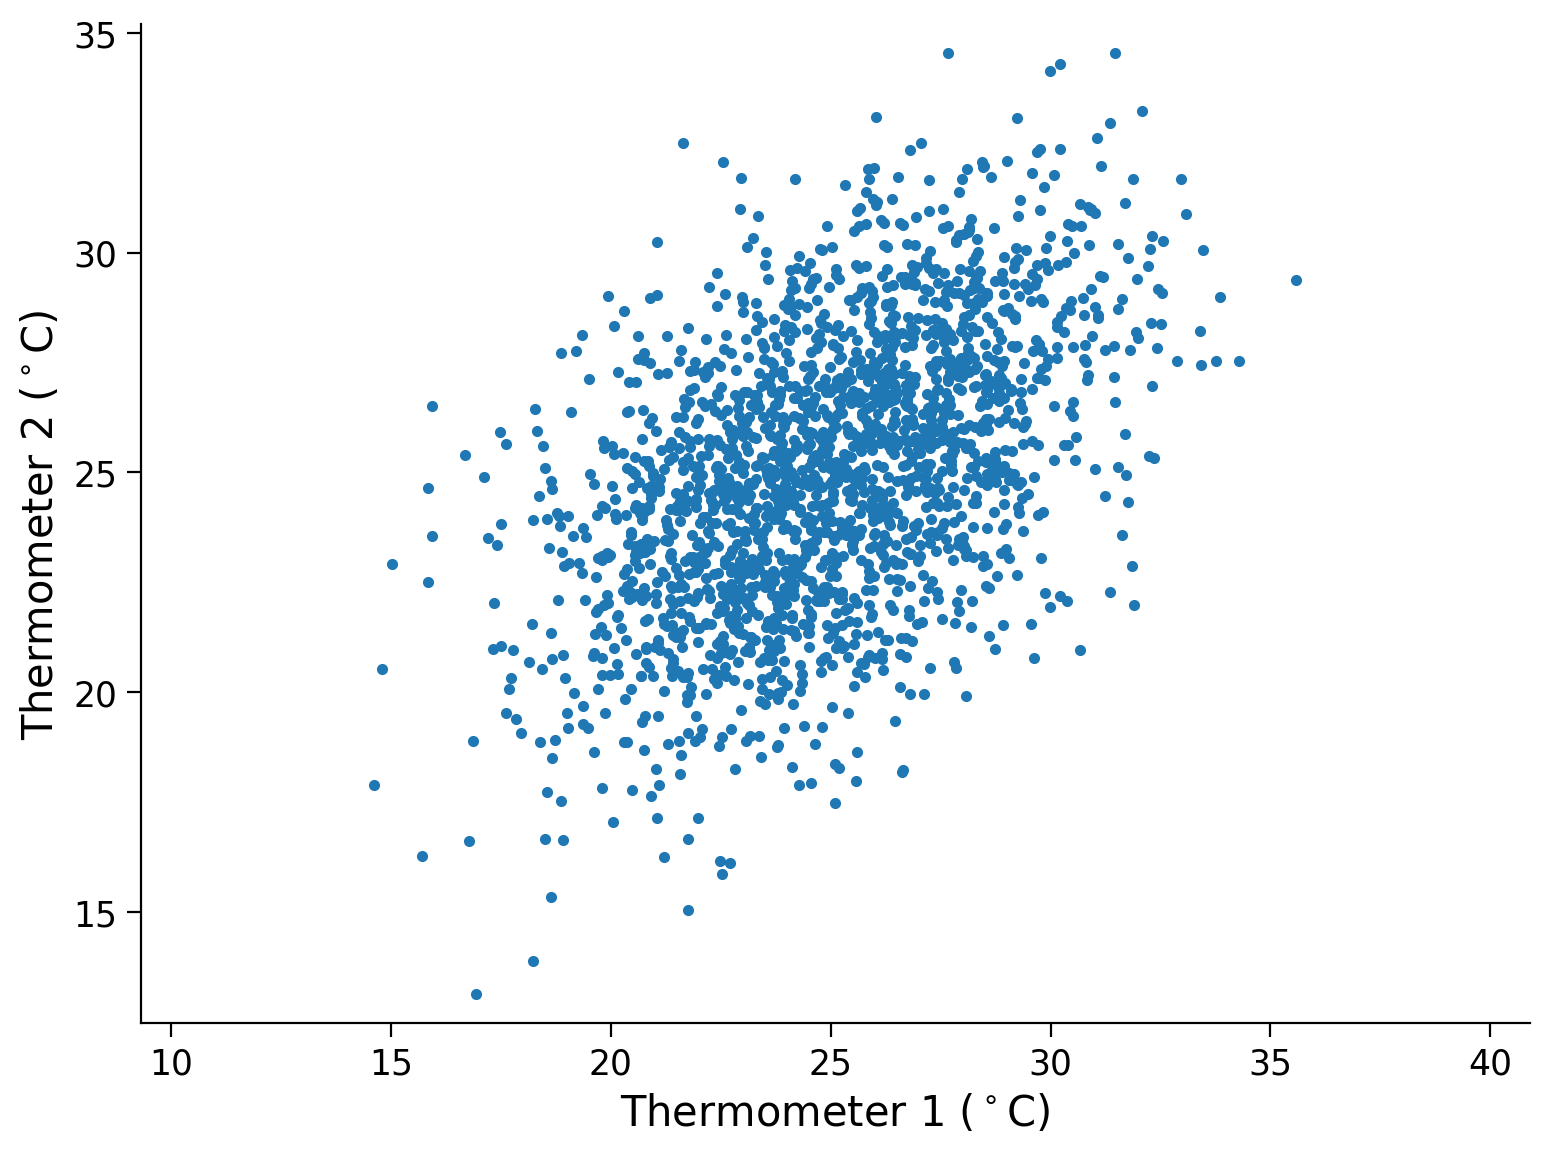

In [19]:
# @markdown Generate example datapoints from the two thermometers

def generate_data(n_samples, mean_of_temps, cov_of_temps, seed):
  """
  Generate random data, normally distributed

  Args:
    n_samples : int
      The number of samples to be generated
    mean_of_temps : numpy.ndarray
      1D array with the mean of temparatures, Kx1
    cov_of_temps : numpy.ndarray
      2D array with the covariance, , KxK
    seed : int
      Set random seed for the psudo random generator

  Returns:
    therm1 : numpy.ndarray
      Thermometer 1
    therm2 : numpy.ndarray
      Thermometer 2
  """

  np.random.seed(seed)
  therm1, therm2 = np.random.multivariate_normal(mean_of_temps,
                                                cov_of_temps,
                                                n_samples).T
  return therm1, therm2


n_samples = 2000
mean_of_temps = np.array([25, 25])
cov_of_temps = np.array([[10, 5], [5, 10]])
therm1, therm2 = generate_data(n_samples, mean_of_temps, cov_of_temps, seed=SEED)

plt.plot(therm1, therm2, '.')
plt.axis('equal')
plt.xlabel('Thermometer 1 ($^\circ$C)')
plt.ylabel('Thermometer 2 ($^\circ$C)')
plt.show()

Let’s model these data with a single principal component. Given that the thermometers are measuring the same actual temperature, the principal component axes will be the identity line. The direction of this axes can be indicated by the unit vector $[1 ~~ 1]~/~\sqrt2$.  We could estimate this axes by applying PCA. We can plot this axes, it tells us something about the data, but we can’t generate from it:

 Add first PC axes to the plot


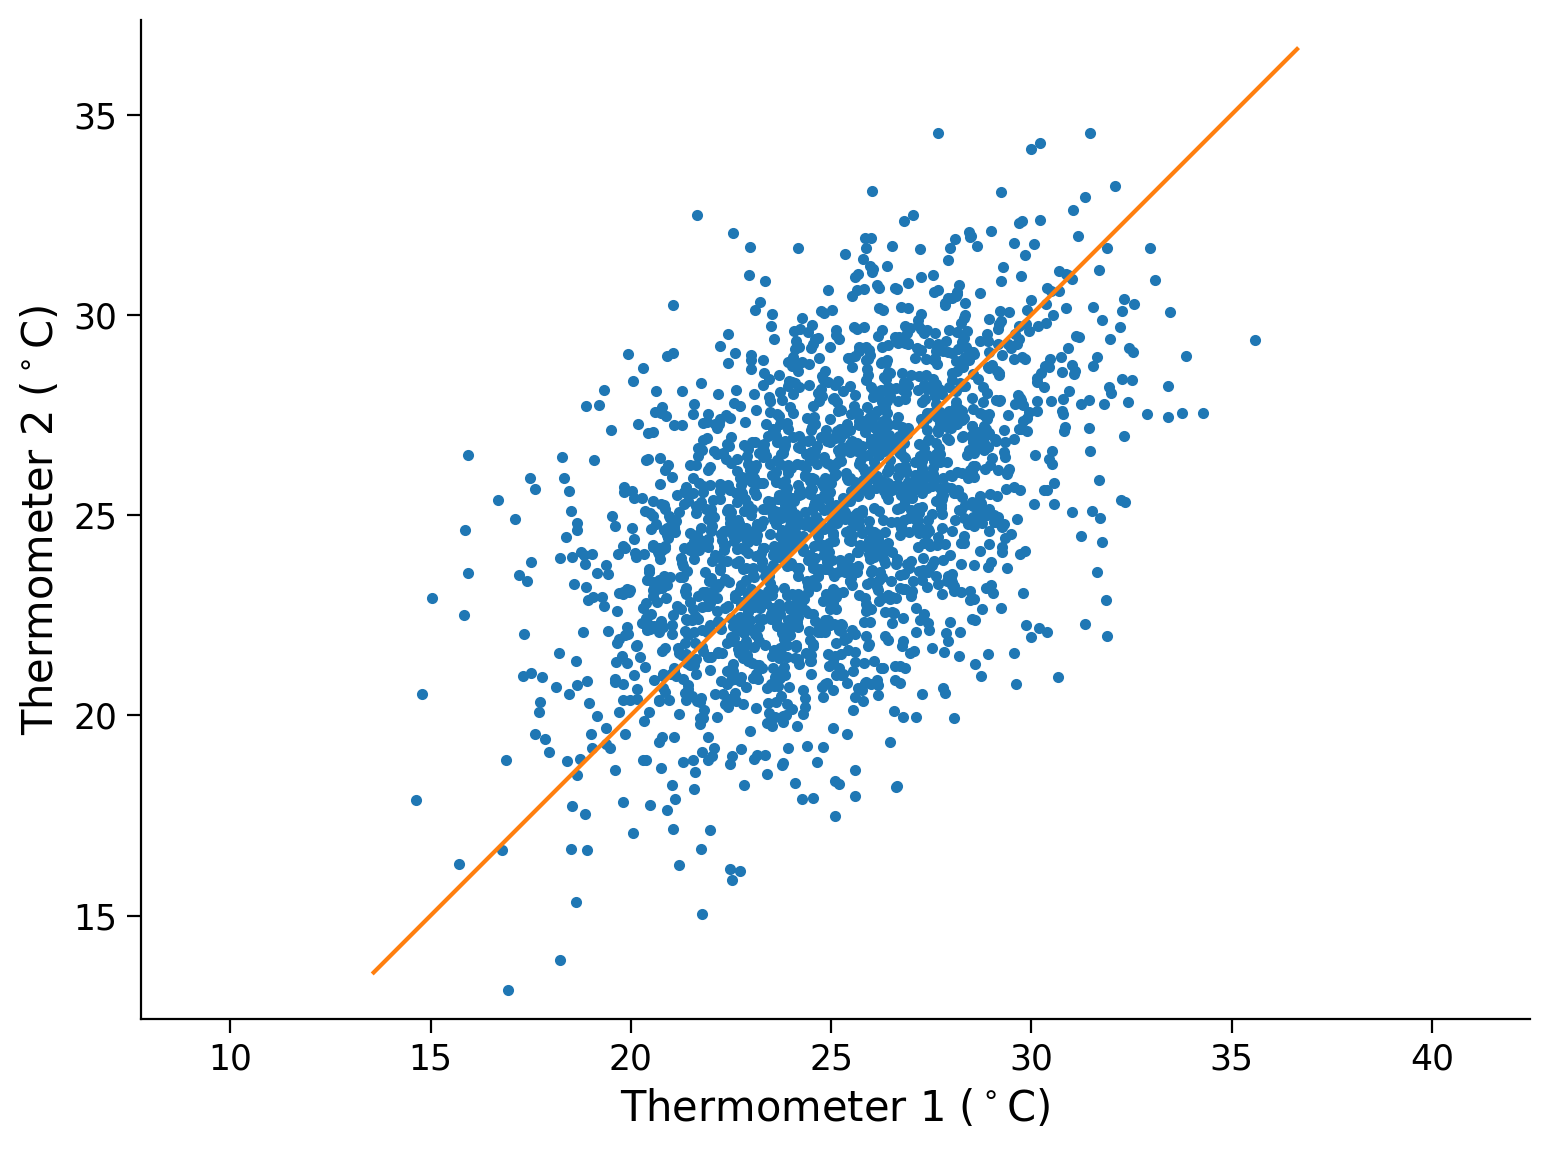

In [20]:
# @markdown Add first PC axes to the plot

plt.plot(therm1, therm2, '.')
plt.axis('equal')
plt.xlabel('Thermometer 1 ($^\circ$C)')
plt.ylabel('Thermometer 2 ($^\circ$C)')
plt.plot([plt.axis()[0], plt.axis()[1]],
         [plt.axis()[0], plt.axis()[1]])
plt.show()

**Step 1:** Calculate the parameters of the pPCA model

This part is completed already, so you don't need to make any edits:

In [21]:
# Project Data onto the principal component axes.
# We could have "learned" this from the data by applying PCA,
# but we "know" the value from the problem definition.
pc_axes = np.array([1.0, 1.0]) / np.sqrt(2.0)

# Thermometers data
therm_data = np.array([therm1, therm2])

# Zero center the data
therm_data_mean = np.mean(therm_data, 1)
therm_data_center = np.outer(therm_data_mean, np.ones(therm_data.shape[1]))
therm_data_zero_centered = therm_data - therm_data_center

# Calculate the variance of the projection on the PC axes
pc_projection = np.matmul(pc_axes, therm_data_zero_centered);
pc_axes_variance = np.var(pc_projection)

# Calculate the residual variance (variance not accounted for by projection on the PC axes)
sensor_noise_std = np.mean(np.linalg.norm(therm_data_zero_centered - np.outer(pc_axes, pc_projection), axis=0, ord=2))
sensor_noise_var = sensor_noise_std **2

**Step 2**: "Generate" from the pPCA model of the thermometer data.

Complete the code so we generate data by sampling according to the pPCA model:

\begin{equation}
x = \mu + W z + \epsilon, \,\text{where}\,~~ \epsilon \sim \mathcal{N}(0,~\sigma^2 \mathbf{I})
\end{equation}

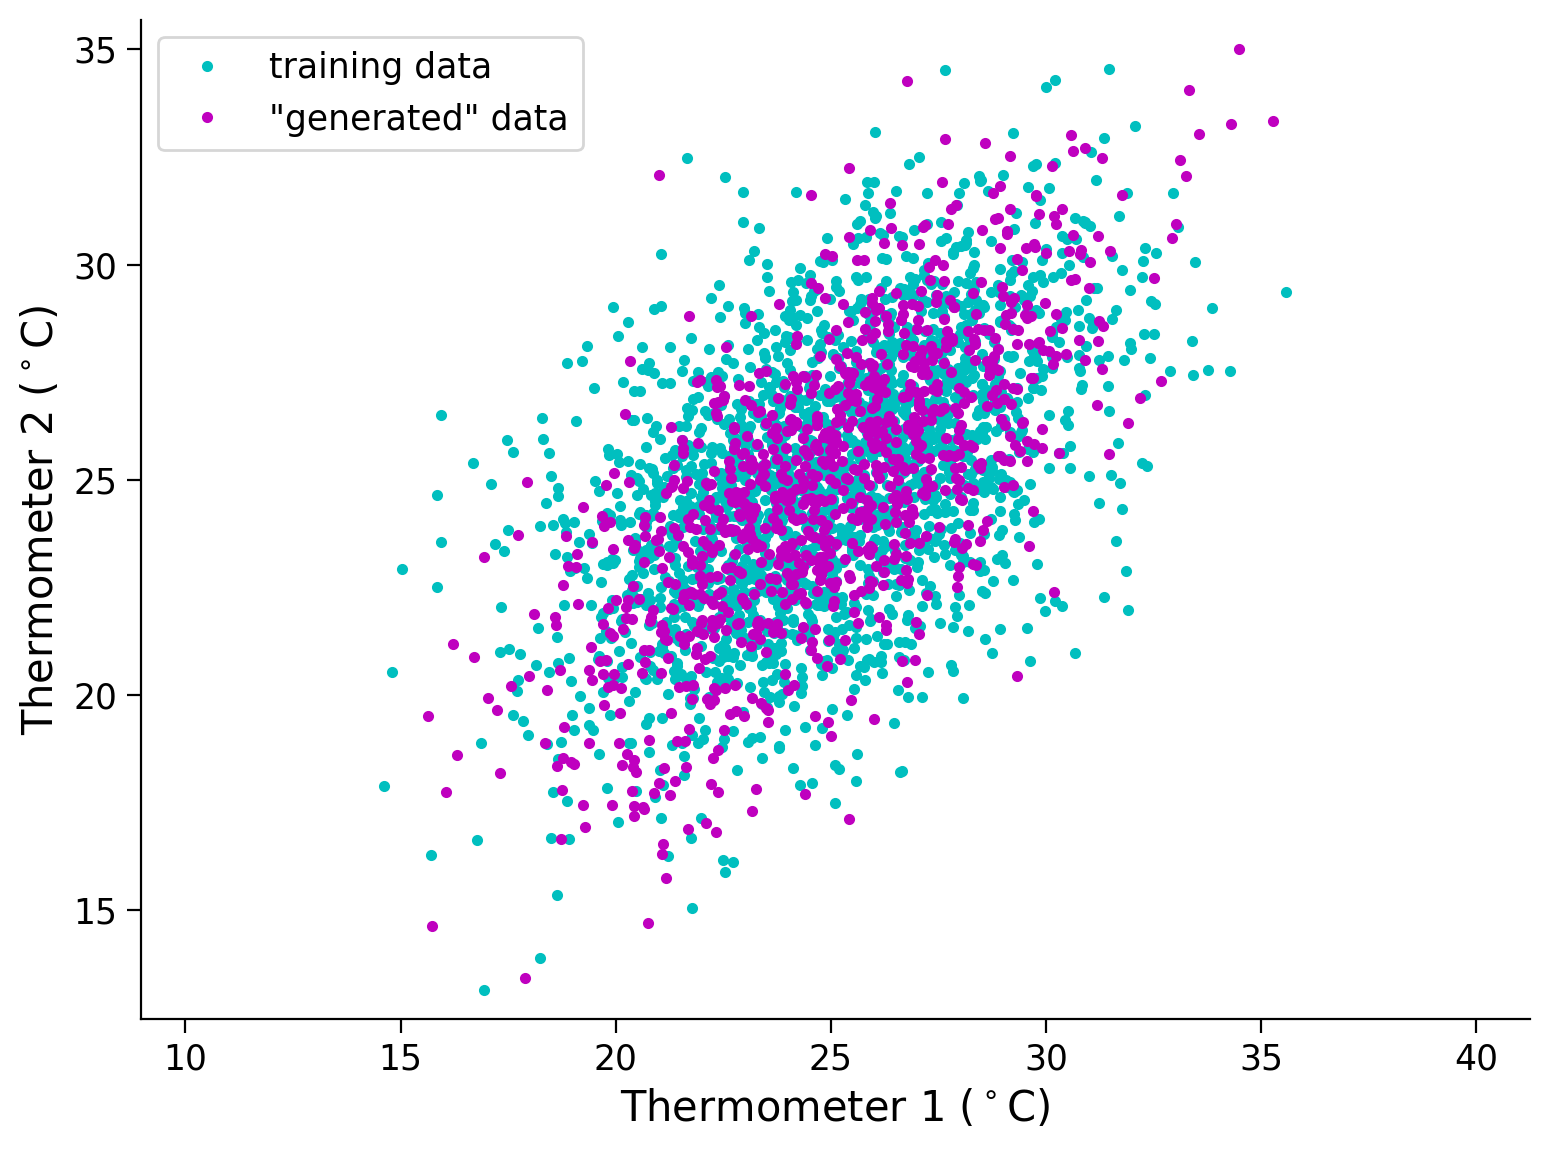

In [23]:
def gen_from_pPCA(noise_var, data_mean, pc_axes, pc_variance):
  """
  Generate samples from pPCA

  Args:
    noise_var: np.ndarray
      Sensor noise variance
    data_mean: np.ndarray
      Thermometer data mean
    pc_axes: np.ndarray
      Principal component axes
    pc_variance: np.ndarray
      The variance of the projection on the PC axes

  Returns:
    therm_data_sim: np.ndarray
      Generated (simulate, draw) `n_samples` from pPCA model
  """
  # We are matching this value to the thermometer data so the visualizations look similar
  n_samples = 1000

  # Randomly sample from z (latent space value)
  z = np.random.normal(0.0, np.sqrt(pc_variance), n_samples)

  # Sensor noise covariance matrix (∑)
  epsilon_cov = [[noise_var, 0.0], [0.0, noise_var]]

  # Data mean reshaped for the generation
  sim_mean = np.outer(data_mean, np.ones(n_samples))

  ####################################################################
  # Fill in all missing code below (...),
  # then remove or comment the line below to test your class
  # raise NotImplementedError("Please complete the `gen_from_pPCA` function")
  ####################################################################
  # Draw `n_samples` from `np.random.multivariate_normal`
  rand_eps = np.random.multivariate_normal(torch.tensor([0.0, 0.0]), torch.tensor(epsilon_cov), n_samples)
  rand_eps = rand_eps.T

  # Generate (simulate, draw) `n_samples` from pPCA model
  therm_data_sim = np.outer(pc_axes, z) + sim_mean + rand_eps

  return therm_data_sim



## Uncomment to test your code
therm_data_sim = gen_from_pPCA(sensor_noise_var, therm_data_mean, pc_axes, pc_axes_variance)
plot_gen_samples_ppca(therm1, therm2, therm_data_sim)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_3b0c285b.py)



###  Submit your feedback


In [24]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Coding_pPCA_Exercise")

---
# Section 3: Autoencoders

*Time estimate: ~30mins*

**Please** run the cell after the video to download MNIST and CIFAR10 image datasets while the video plays.

##  Video 3: Autoencoders


In [25]:
# @title Video 3: Autoencoders
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'MlyIL1PmDCA'), ('Bilibili', 'BV16b4y167Z2')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

##  Submit your feedback


In [26]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Autoencoders_Video")

 Download MNIST and CIFAR10 datasets


In [27]:
# @markdown Download MNIST and CIFAR10 datasets
import tarfile, requests, os

fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'

if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed!\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been downloaded.\n')


fname = 'cifar-10-python.tar.gz'
name = 'cifar10'
url = 'https://osf.io/jbpme/download'

if not os.path.exists(name):
  print('\nDownloading CIFAR10 dataset...')
  r = requests.get(url, allow_redirects=True)
  with open(fname, 'wb') as fh:
    fh.write(r.content)
  print('\nDownloading CIFAR10 completed!')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('CIFAR10 dataset has been dowloaded.')

 Load MNIST and CIFAR10 image datasets


In [28]:
# @markdown Load MNIST and CIFAR10 image datasets
# See https://pytorch.org/docs/stable/torchvision/datasets.html

# MNIST
mnist = datasets.MNIST('./mnist/',
                       train=True,
                       transform=transforms.ToTensor(),
                       download=False)
mnist_val = datasets.MNIST('./mnist/',
                           train=False,
                           transform=transforms.ToTensor(),
                           download=False)

# CIFAR 10
cifar10 = datasets.CIFAR10('./cifar10/',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=False)
cifar10_val = datasets.CIFAR10('./cifar10/',
                               train=False,
                               transform=transforms.ToTensor(),
                               download=False)

### Select a dataset

We've built today's tutorial to be flexible. It should work more-or-less out of the box with both MNIST and CIFAR (and other image datasets). MNIST is in many ways simpler, and the results will likely look better and run a bit faster if using MNIST. But we are leaving it up to you to pick which one you want to experiment with!

We encourage pods to coordinate so that some members use MNIST and others use CIFAR10. Keep in mind that the CIFAR dataset may require more learning epochs (longer training required).

Change the variable `dataset_name` below to pick your dataset.


 Execute this cell to enable helper function `get_data`


In [29]:
# @markdown Execute this cell to enable helper function `get_data`

def get_data(name='mnist'):
  """
  Get data

  Args:
    name: string
      Name of the dataset

  Returns:
    my_dataset: dataset instance
      Instance of dataset
    my_dataset_name: string
      Name of the dataset
    my_dataset_shape: tuple
      Shape of dataset
    my_dataset_size: int
      Size of dataset
    my_valset: torch.loader
      Validation loader
  """
  if name == 'mnist':
    my_dataset_name = "MNIST"
    my_dataset = mnist
    my_valset = mnist_val
    my_dataset_shape = (1, 28, 28)
    my_dataset_size = 28 * 28
  elif name == 'cifar10':
    my_dataset_name = "CIFAR10"
    my_dataset = cifar10
    my_valset = cifar10_val
    my_dataset_shape = (3, 32, 32)
    my_dataset_size = 3 * 32 * 32

  return my_dataset, my_dataset_name, my_dataset_shape, my_dataset_size, my_valset

In [30]:
dataset_name = 'mnist'  # This can be mnist or cifar10
train_set, dataset_name, data_shape, data_size, valid_set = get_data(name=dataset_name)

## Section 3.1: Conceptual introduction to AutoEncoders

Now we'll create our first autoencoder. It will reduce images down to $K$ dimensions. The architecture will be quite simple: the input will be linearly mapped to a single hidden (or latent) layer $\mathbf{h}$ with $K$ units, which will then be linearly mapped back to an output that is the same size as the input:

\begin{equation}
\mathbf{x} \longrightarrow \mathbf{h} \longrightarrow \mathbf{x'}
\end{equation}

The loss function we'll use will simply be mean squared error (MSE) quantifying how well the reconstruction ($\mathbf{x'}$) matches the original image ($\mathbf{x}$):

\begin{equation}
\text{MSE Loss} = \sum_{i=1}^{N} ||\mathbf{x}_i - \mathbf{x'}_i||^2_2
\end{equation}

If all goes well, then the AutoEncoder will learn, **end to end**, a good "encoding" or "compression" of inputs to a latent representation ($\mathbf{x \longrightarrow h}$) as well as a good "decoding" of that latent representation to a reconstruction of the original input ($\mathbf{h \longrightarrow x'}$).

We first need to choose our desired dimensionality of $\mathbf{h}$. We'll see more on this below, but for MNIST, 5 to 20 is plenty. For CIFAR, we need more like 50 to 100 dimensions.

Coordinate with your pod to try a variety of values for $K$ in each dataset so you can compare results.

### Coding Exercise 3.1: Linear AutoEncoder Architecture

Complete the missing parts of the `LinearAutoEncoder` class. We're back to using PyTorch in this exercise.

The `LinearAutoEncoder` as two stages: an `encoder` which linearly maps from inputs of size `x_dim = my_dataset_dim` to a hidden layer of size `h_dim = K` (with no nonlinearity), and a `decoder` which maps back from `K` up to the number of pixels in each image.

In [31]:
# @markdown #### Run to define the `train_autoencoder` function.
# @markdown Feel free to inspect the training function if the time allows.

# @markdown `train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250, seed=0)`


def train_autoencoder(autoencoder, dataset, device, epochs=20, batch_size=250,
                      seed=0):
  """
  Function to train autoencoder

  Args:
    autoencoder: nn.module
      Autoencoder instance
    dataset: function
      Dataset
    device: string
      GPU if available. CPU otherwise
    epochs: int
      Number of epochs [default: 20]
    batch_size: int
      Batch size
    seed: int
      Set seed for reproducibility; [default: 0]

  Returns:
    mse_loss: float
      MSE Loss
  """
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),
                           lr=1e-3,
                           weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      worker_init_fn=seed_worker,
                      generator=g_seed)

  mse_loss = torch.zeros(epochs * len(dataset) // batch_size, device=device)
  i = 0
  for epoch in trange(epochs, desc='Epoch'):
    for im_batch, _ in loader:
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      # Loss calculation
      loss = loss_fn(reconstruction.view(batch_size, -1),
                     target=im_batch.view(batch_size, -1))
      loss.backward()
      optim.step()

      mse_loss[i] = loss.detach()
      i += 1
  # After training completes,
  # make sure the model is on CPU so we can easily
  # do more visualizations and demos.
  autoencoder.to('cpu')
  return mse_loss.cpu()

Random seed 2021 has been set.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

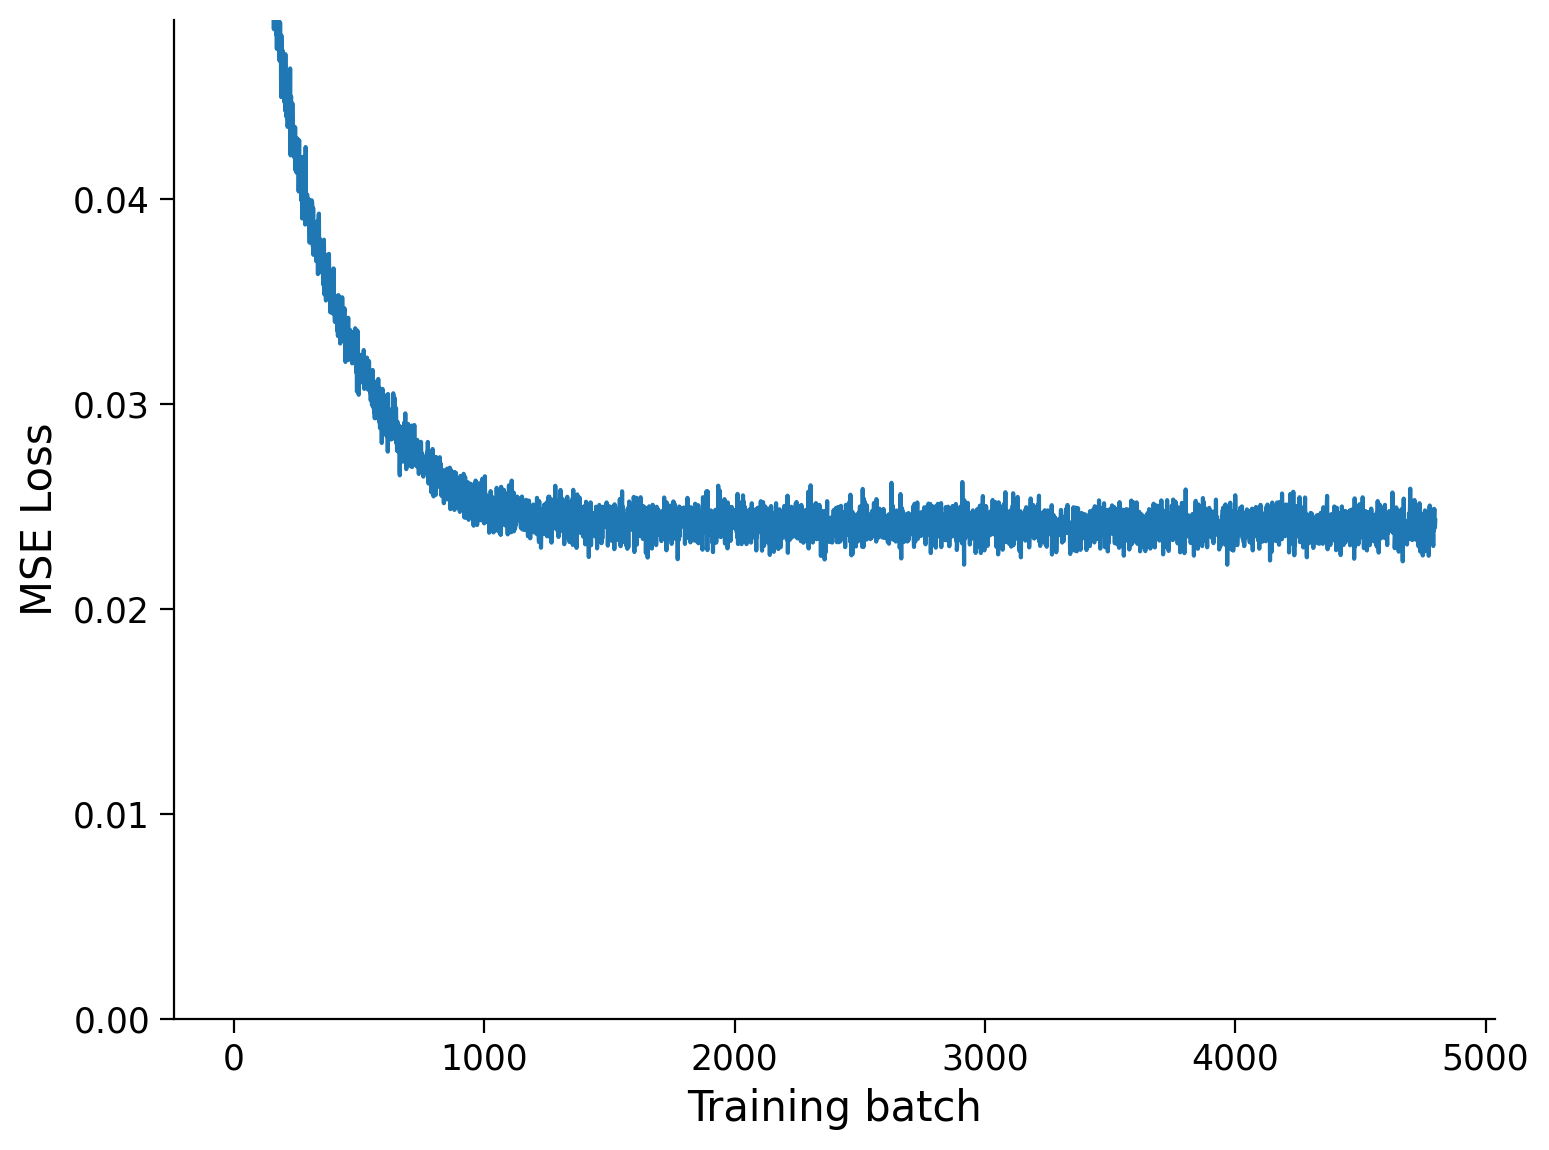

In [33]:
class LinearAutoEncoder(nn.Module):
  """
  Linear Autoencoder
  """

  def __init__(self, x_dim, h_dim):
    """
    A Linear AutoEncoder

    Args:
      x_dim: int
        Input dimension
      h_dim: int
        Hidden dimension, bottleneck dimension, K

    Returns:
      Nothing
    """
    super().__init__()
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your class
    # raise NotImplementedError("Please complete the LinearAutoEncoder class!")
    ####################################################################
    # Encoder layer (a linear mapping from x_dim to K)
    self.enc_lin = nn.Linear(x_dim, h_dim)
    # Decoder layer (a linear mapping from K to x_dim)
    self.dec_lin = nn.Linear(h_dim, x_dim)

  def encode(self, x):
    """
    Encoder function

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Encoded output
    """
    ####################################################################
    # Fill in all missing code below (...),
    # raise NotImplementedError("Please complete the `encode` function!")
    ####################################################################
    h = self.enc_lin(x)
    return h

  def decode(self, h):
    """
    Decoder function

    Args:
      h: torch.tensor
        Encoded output

    Returns:
      x_prime: torch.tensor
        Decoded output
    """
    ####################################################################
    # Fill in all missing code below (...),
    # raise NotImplementedError("Please complete the `decode` function!")
    ####################################################################
    x_prime = self.dec_lin(h)
    return x_prime

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input data

    Returns:
      Decoded output
    """
    flat_x = x.view(x.size(0), -1)
    h = self.encode(flat_x)
    return self.decode(h).view(x.size())

# Pick your own K
K = 20
set_seed(seed=SEED)
## Uncomment to test your code
lin_ae = LinearAutoEncoder(data_size, K)
lin_losses = train_autoencoder(lin_ae, train_set, device=DEVICE, seed=SEED)
plot_linear_ae(lin_losses)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_3872c34f.py)



####  Submit your feedback


In [34]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Linear_Autoencoder_Exercise")

### Comparison to PCA

One way to think about AutoEncoders is as a form of dimensionality-reduction. The dimensionality of $\mathbf{h}$ is much smaller than the dimensionality of $\mathbf{x}$.

Another common technique for dimensionality reduction is to project data onto the top $K$ **principal components** (Principal Component Analysis or PCA). For comparison, let's also apply PCA for dimensionality reduction. The following cell will do this using the same value of K as you chose for the linear autoencoder.

In [35]:
# PCA requires finding the top K eigenvectors of the data covariance. Start by
# finding the mean and covariance of the pixels in our dataset
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

loader = DataLoader(train_set,
                    batch_size=32,
                    pin_memory=True,
                    num_workers=2,
                    worker_init_fn=seed_worker,
                    generator=g_seed)

mu, cov = image_moments((im for im, _ in loader),
                        n_batches=len(train_set) // 32)

pca_encode, pca_decode = pca_encoder_decoder(mu, cov, K)

Computing pixel mean and covariance...:   0%|          | 0/1875 [00:00<?, ?it/s]

Let's visualize some of the reconstructions ($\mathbf{x'}$) side-by-side with the input images ($\mathbf{x}$).

 Visualize the reconstructions $\mathbf{x}'$, run this code a few times to see different examples.


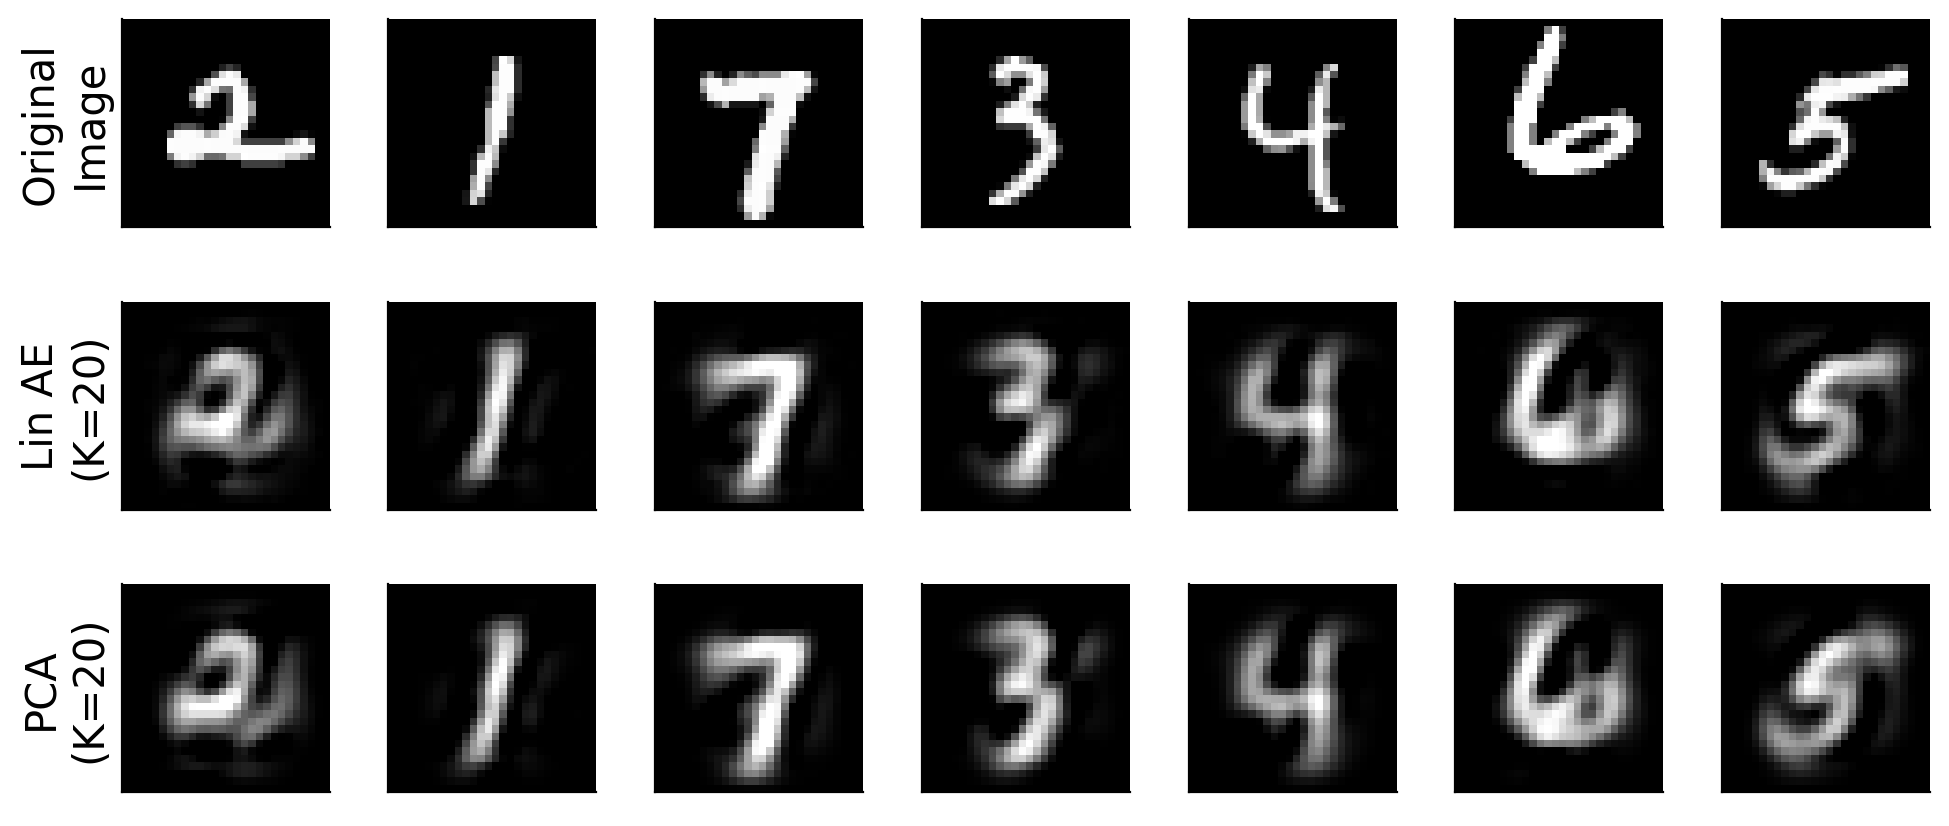

In [36]:
# @markdown Visualize the reconstructions $\mathbf{x}'$, run this code a few times to see different examples.

n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(train_set), size=())
  image, _ = train_set[idx]
  # Get reconstructed image from autoencoder
  with torch.no_grad():
    reconstruction = lin_ae(image.unsqueeze(0)).reshape(image.size())

  # Get reconstruction from PCA dimensionality reduction
  h_pca = pca_encode(image)
  recon_pca = pca_decode(h_pca).reshape(image.size())

  plt.subplot(3, n_plot, i + 1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(reconstruction)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(recon_pca)
  if i == 0:
    plt.ylabel(f'PCA\n(K={K})')
plt.show()

### Think! 3.1: PCA vs. Linear autoenconder

Compare the PCA-based reconstructions to those from the linear autoencoder. Is one better than the other? Are they equally good? Equally bad?

Try out the above cells with a couple values of K if possible. How does the choice of $K$ impact reconstruction quality?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_2cc24bef.py)



####  Submit your feedback


In [37]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_PCA_vs_LinearAutoEncoder")

## Section 3.2: Building a nonlinear convolutional autoencoder

Ok so we have linear autoencoders doing about the same thing as PCA. We want to improve on that though! We can do so by adding nonlinearity and convolutions.

**Nonlinear:** We'd like to apply autoencoders to learn a more flexible nonlinear mapping between the latent space and the images. Such a mapping can provide a more "expressive" model that better describes the image data than a linear mapping. This can be achieved by adding nonlinear activation functions to our encoder and decoder!

**Convolutional:** As you saw on the day dedicated to RNNs and CNNs, parameter sharing is often a good idea for images! It's quite common to use convolutional layers in autoencoders to share parameters across locations in the image.

**Side Note:** The `nn.Linear` layer (used in the linear autoencoder above) has a "bias" term, which is a learnable offset parameter separate for each output unit. Just like PCA "centers" the data by subtracting off the mean image (`mu`) before encoding and adds the average back in during decoding, a bias term in the decoder can effectively account for the first moment (mean) of the data (i.e. the average of all images in the training set). Convolution layers do have bias parameters, but the bias is applied per filter rather than per pixel location. If we're generating grayscale images (like those in MNIST), then `Conv2d` will learn only one bias across the entire image.

For some conceptual continuity with both PCA and the `nn.Linear` layers above, the next block defines a custom `BiasLayer` for adding a learnable per-pixel offset. This custom layer will be used twice: as the first stage of the encoder and as the final stage of the decoder. Ideally, this means that the rest of the neural net can focus on fitting more interesting fine-grained structure.

In [38]:
class BiasLayer(nn.Module):
  """
  Bias Layer
  """

  def __init__(self, shape):
    """
    Initialise parameters of bias layer

    Args:
      shape: tuple
        Requisite shape of bias layer

    Returns:
      Nothing
    """
    super(BiasLayer, self).__init__()
    init_bias = torch.zeros(shape)
    self.bias = nn.Parameter(init_bias, requires_grad=True)

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input features

    Returns:
      Output of bias layer
    """
    return x + self.bias

With that out of the way, we will next define a **nonlinear** and **convolutional** autoencoder. Here's a quick tour of the architecture:

1. The **encoder** once again maps from images to $\mathbf{h}\in\mathbb{R}^K$. This will use a `BiasLayer` followed by two convolutional layers (`nn.Conv2D`), followed by flattening and linearly projecting down to $K$ dimensions. The convolutional layers will have `ReLU` nonlinearities on their outputs.
1. The **decoder** inverts this process, taking in vectors of length $K$ and outputting images. Roughly speaking, its architecture is a "mirror image" of the encoder: the first decoder layer is linear, followed by two **deconvolution** layers ([`ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)). The `ConvTranspose2d`layers will have `ReLU` nonlinearities on their _inputs_. This "mirror image" between the encoder and decoder is a useful and near-ubiquitous convention. The idea is that the decoder can then learn to approximately invert the encoder, but it is not a strict requirement (and it does not guarantee the decoder will be an exact inverse of the encoder!).

Below is a schematic of the architecture for MNIST. Notice that the width and height dimensions of the image planes reduce after each `nn.Conv2d` and increase after each `nn.ConvTranspose2d`. With CIFAR10, the architecture is the same but the exact sizes will differ.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D4_GenerativeModels/static/conv_sizes.png">

[`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) module can be seen as the gradient of `Conv2d` with respect to its input. It is also known as a fractionally-strided convolution or a deconvolution (although it is not an actual deconvolution operation). The following code demonstrates this change in sizes:

In [39]:
dummy_image = torch.rand(data_shape).unsqueeze(0)
in_channels = data_shape[0]
out_channels = 7

dummy_conv = nn.Conv2d(in_channels=in_channels,
                       out_channels=out_channels,
                       kernel_size=5)

dummy_deconv = nn.ConvTranspose2d(in_channels=out_channels,
                                  out_channels=in_channels,
                                  kernel_size=5)

print(f'Size of image is {dummy_image.shape}')
print(f'Size of Conv2D(image) {dummy_conv(dummy_image).shape}')
print(f'Size of ConvTranspose2D(Conv2D(image)) {dummy_deconv(dummy_conv(dummy_image)).shape}')

Size of image is torch.Size([1, 1, 28, 28])
Size of Conv2D(image) torch.Size([1, 7, 24, 24])
Size of ConvTranspose2D(Conv2D(image)) torch.Size([1, 1, 28, 28])


### Coding Exercise 3.2: Fill in code for the `ConvAutoEncoder` module

Complete the `ConvAutoEncoder` class. We use the helper function `cout(torch.Tensor, nn.Conv2D)` to calculate the output shape of a [`nn.Conv2D`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer given a tensor with shape (channels, height, width).

It will use the value for **K** you defined in Coding Exercise 3.1 as we will eventually compare the results of the linear autoencoder that you trained there with this one. To play around with K, change it there and retrain both the linear autoencoder and the convolutional autoencoders.

**Do you expect the convolutional autoencoder or the linear autoencoder to reach a lower value of mean squared error (MSE)?**

Random seed 2021 has been set.


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

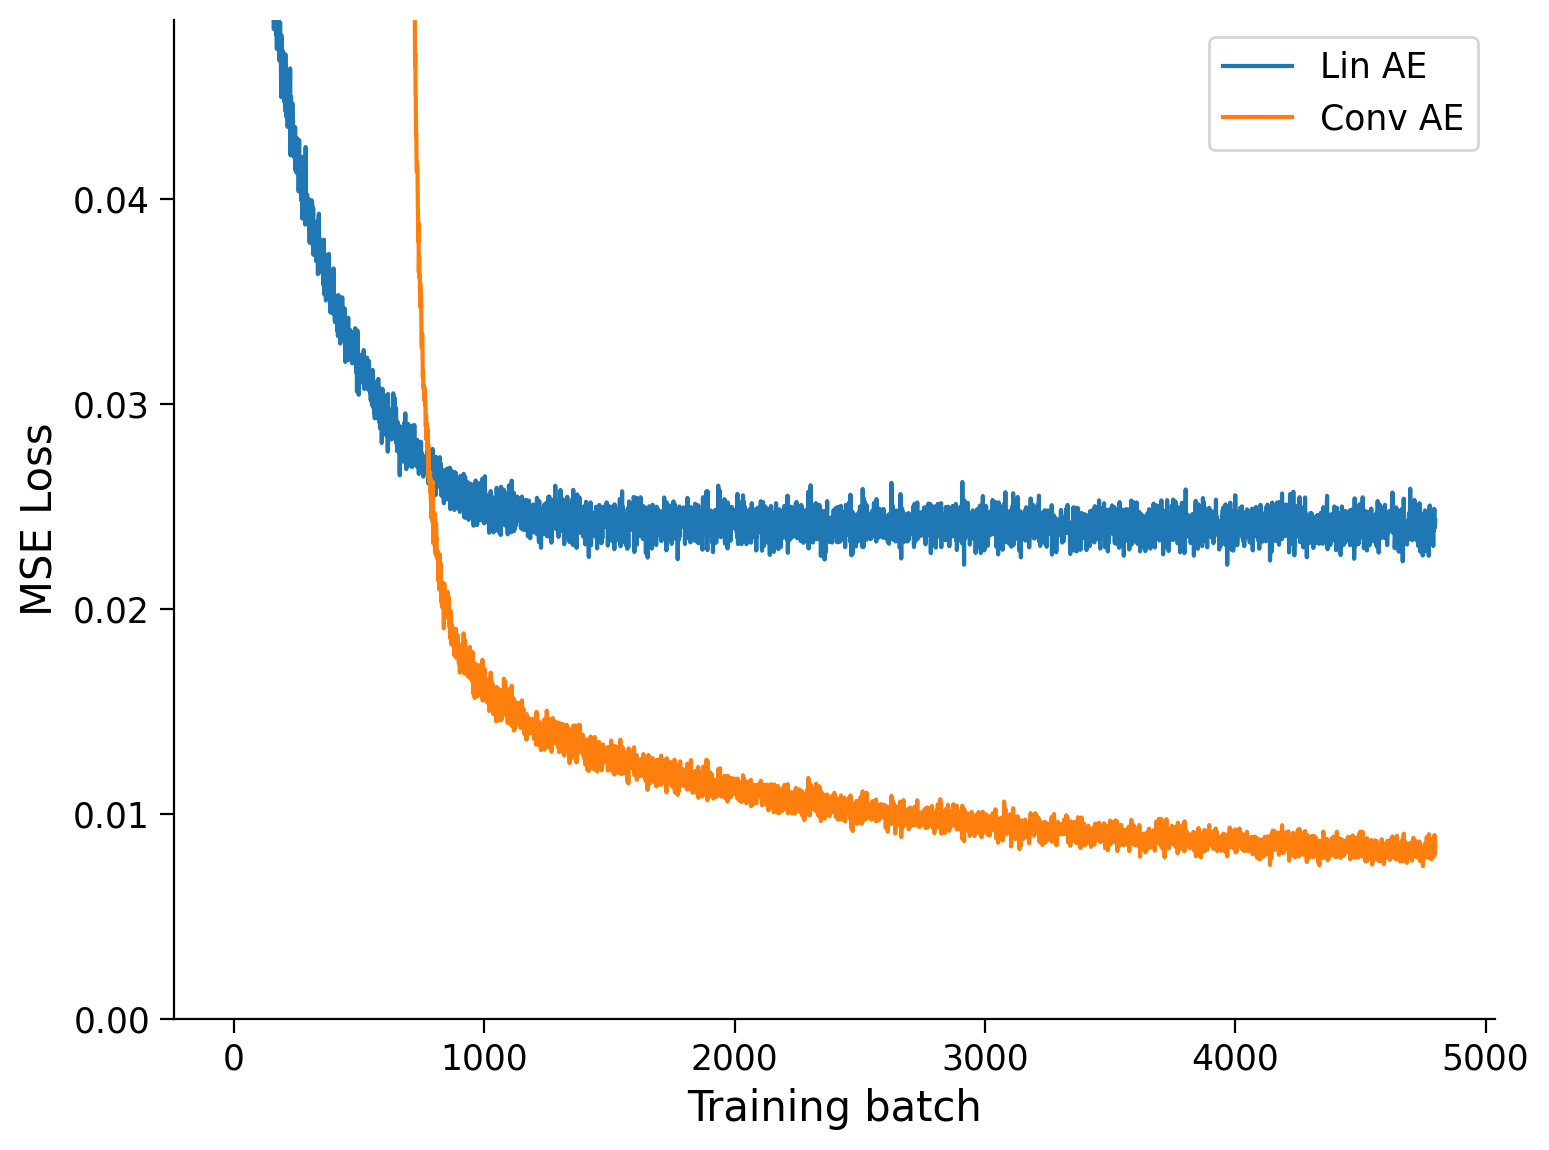

In [44]:
import torch.nn as nn
import torch.nn.functional as F

def cout(input_shape, conv_layer):
  """
  Calculate the output shape of a convolutional layer

  Args:
    input_shape: tuple
    Input dimensions (channels, height, width)
    conv_layer: nn.Conv2d
    Convolutional layer

  Returns:
    output_shape: tuple
    Output dimensions (channels, height, width)
  """
  channels, height, width = input_shape
  kernel_size = conv_layer.kernel_size[0]
  stride = conv_layer.stride[0]
  padding = conv_layer.padding[0]
  dilation = conv_layer.dilation[0]

  height_out = (height + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
  width_out = (width + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1

  return (conv_layer.out_channels, height_out, width_out)

class BiasLayer(nn.Module):
  """
  A layer that adds a learnable bias to the input
  """

  def __init__(self, input_shape):
    """
    Initialize parameters of BiasLayer

    Args:
      input_shape: tuple
      Input dimensions (channels, height, width)

    Returns:
      Nothing
    """
    super().__init__()
    self.bias = nn.Parameter(torch.zeros(input_shape))

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
      Input features

    Returns:
      Output with added bias
    """
    return x + self.bias

# Decoder Linear layer
# Second "deconvolution" layer
class ConvAutoEncoder(nn.Module):
  """
  A Convolutional AutoEncoder
  """

  def __init__(self, x_dim, h_dim, n_filters=32, filter_size=5):
    """
    Initialize parameters of ConvAutoEncoder

    Args:
      x_dim: tuple
        Input dimensions (channels, height, widths)
      h_dim: int
        Hidden dimension, bottleneck dimension, K
      n_filters: int
        Number of filters (number of output channels)
      filter_size: int
        Kernel size

    Returns:
      Nothing
    """
    super().__init__()
    channels, height, widths = x_dim

    # Encoder input bias layer
    self.enc_bias = BiasLayer(x_dim)

    # First encoder conv2d layer
    self.enc_conv_1 = nn.Conv2d(channels, n_filters, filter_size)

    # Output shape of the first encoder conv2d layer given x_dim input
    conv_1_shape = cout(x_dim, self.enc_conv_1)

    # Second encoder conv2d layer
    self.enc_conv_2 = nn.Conv2d(n_filters, n_filters, filter_size)

    # Output shape of the second encoder conv2d layer given conv_1_shape input
    conv_2_shape = cout(conv_1_shape, self.enc_conv_2)

    # The bottleneck is a dense layer, therefore we need a flattenning layer
    self.enc_flatten = nn.Flatten()

    # Conv output shape is (depth, height, width), so the flatten size is:
    flat_after_conv = conv_2_shape[0] * conv_2_shape[1] * conv_2_shape[2]

    # Encoder Linear layer
    self.enc_lin = nn.Linear(flat_after_conv, h_dim)

    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your class
    # Remember that decoder is "undo"-ing what the encoder has done!
    # raise NotImplementedError("Please complete the `ConvAutoEncoder` class!")
    ####################################################################
    # Decoder Linear layer
    self.dec_lin = nn.Linear(h_dim, flat_after_conv)

    # Unflatten data to (depth, height, width) shape
    self.dec_unflatten = nn.Unflatten(dim=-1, unflattened_size=conv_2_shape)

    # First "deconvolution" layer
    self.dec_deconv_1 = nn.ConvTranspose2d(n_filters, n_filters, filter_size)

    # Second "deconvolution" layer
    self.dec_deconv_2 = nn.ConvTranspose2d(n_filters, channels, filter_size)

    # Decoder output bias layer
    self.dec_bias = BiasLayer(x_dim)

  def encode(self, x):
    """
    Encoder

    Args:
      x: torch.tensor
        Input features

    Returns:
      h: torch.tensor
        Encoded output
    """
    s = self.enc_bias(x)
    s = F.relu(self.enc_conv_1(s))
    s = F.relu(self.enc_conv_2(s))
    s = self.enc_flatten(s)
    h = self.enc_lin(s)
    return h

  def decode(self, h):
    """
    Decoder

    Args:
      h: torch.tensor
        Encoded output

    Returns:
      x_prime: torch.tensor
        Decoded output
    """
    s = F.relu(self.dec_lin(h))
    s = self.dec_unflatten(s)
    s = F.relu(self.dec_deconv_1(s))
    s = self.dec_deconv_2(s)
    x_prime = self.dec_bias(s)
    return x_prime

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input features

    Returns:
      Decoded output
    """
    return self.decode(self.encode(x))



set_seed(seed=SEED)
## Uncomment to test your solution
trained_conv_AE = ConvAutoEncoder(data_shape, K)
assert trained_conv_AE.encode(train_set[0][0].unsqueeze(0)).numel() == K, "Encoder output size should be K!"
conv_losses = train_autoencoder(trained_conv_AE, train_set, device=DEVICE, seed=SEED)
plot_conv_ae(lin_losses, conv_losses)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_71a661e8.py)



You should see that the `ConvAutoEncoder` achieved lower MSE loss than the linear one. If not, you may need to retrain it (or run another few training epochs from where it left off). We make fewer guarantees on this working with CIFAR10, but it should definitely work with MNIST.

Now let's visually compare the reconstructed images from the linear and nonlinear autoencoders. Keep in mind that both have the same dimensionality for $\mathbf{h}$!

 Visualize the linear and nonlinear AE outputs


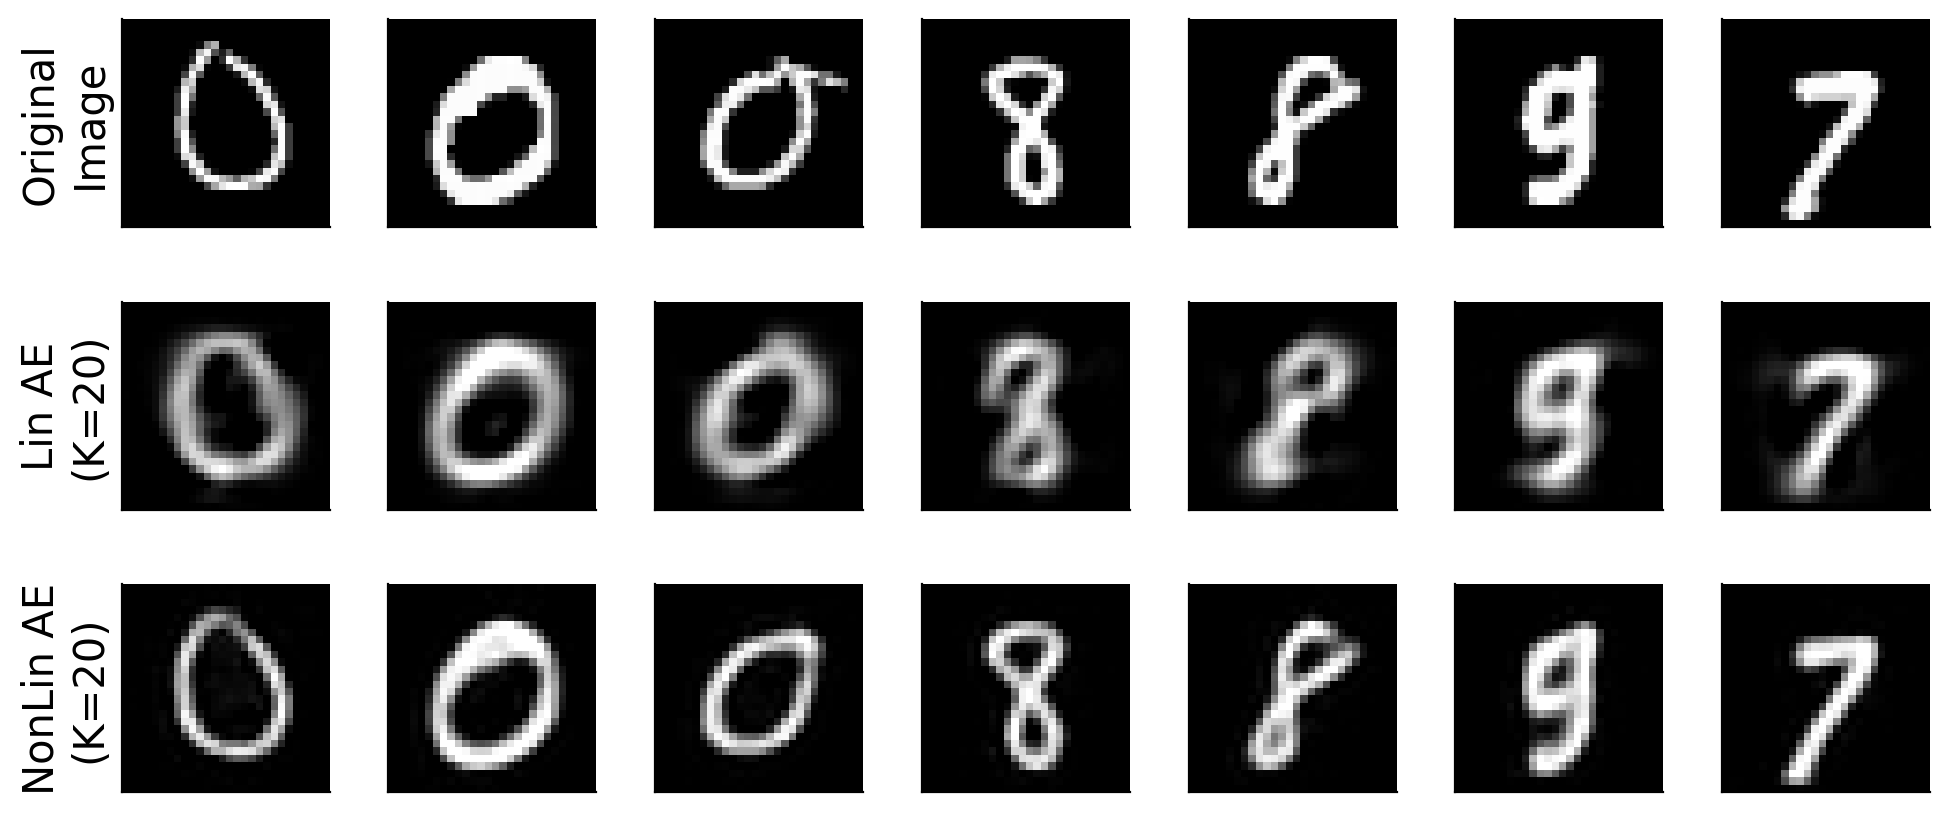

In [45]:
# @markdown Visualize the linear and nonlinear AE outputs
if lin_ae.enc_lin.out_features != trained_conv_AE.enc_lin.out_features:
   raise ValueError('ERROR: your linear and convolutional autoencoders have different values of K')

n_plot = 7
plt.figure(figsize=(10, 4.5))
for i in range(n_plot):
  idx = torch.randint(len(train_set), size=())
  image, _ = train_set[idx]
  with torch.no_grad():
    # Get reconstructed image from linear autoencoder
    lin_recon = lin_ae(image.unsqueeze(0))[0]

    # Get reconstruction from deep (nonlinear) autoencoder
    nonlin_recon = trained_conv_AE(image.unsqueeze(0))[0]

  plt.subplot(3, n_plot, i+1)
  plot_torch_image(image)
  if i == 0:
    plt.ylabel('Original\nImage')

  plt.subplot(3, n_plot, i + 1 + n_plot)
  plot_torch_image(lin_recon)
  if i == 0:
    plt.ylabel(f'Lin AE\n(K={K})')

  plt.subplot(3, n_plot, i + 1 + 2*n_plot)
  plot_torch_image(nonlin_recon)
  if i == 0:
    plt.ylabel(f'NonLin AE\n(K={K})')
plt.show()

####  Submit your feedback


In [46]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_NonLinear_AutoEncoder_Exercise")

---
# Section 4: Variational Auto-Encoders (VAEs)

*Time estimate: ~25mins*

**Please** run the cell after the video to train a VAE for MNIST while watching it.

##  Video 4: Variational Autoencoders


In [47]:
# @title Video 4: Variational Autoencoders
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'srWb_Gp6OGA'), ('Bilibili', 'BV17v411E7ye')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

##  Submit your feedback


In [48]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Variational_AutoEncoder_Video")

 Train a VAE for MNIST while watching the video. (Note: this VAE has a 2D latent space. If you are feeling ambitious, edit the code and modify the latent space dimensionality and see what happens.)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Batches:   0%|          | 0/240 [00:00<?, ?it/s]

Learned sigma_x is 0.20961731672286987


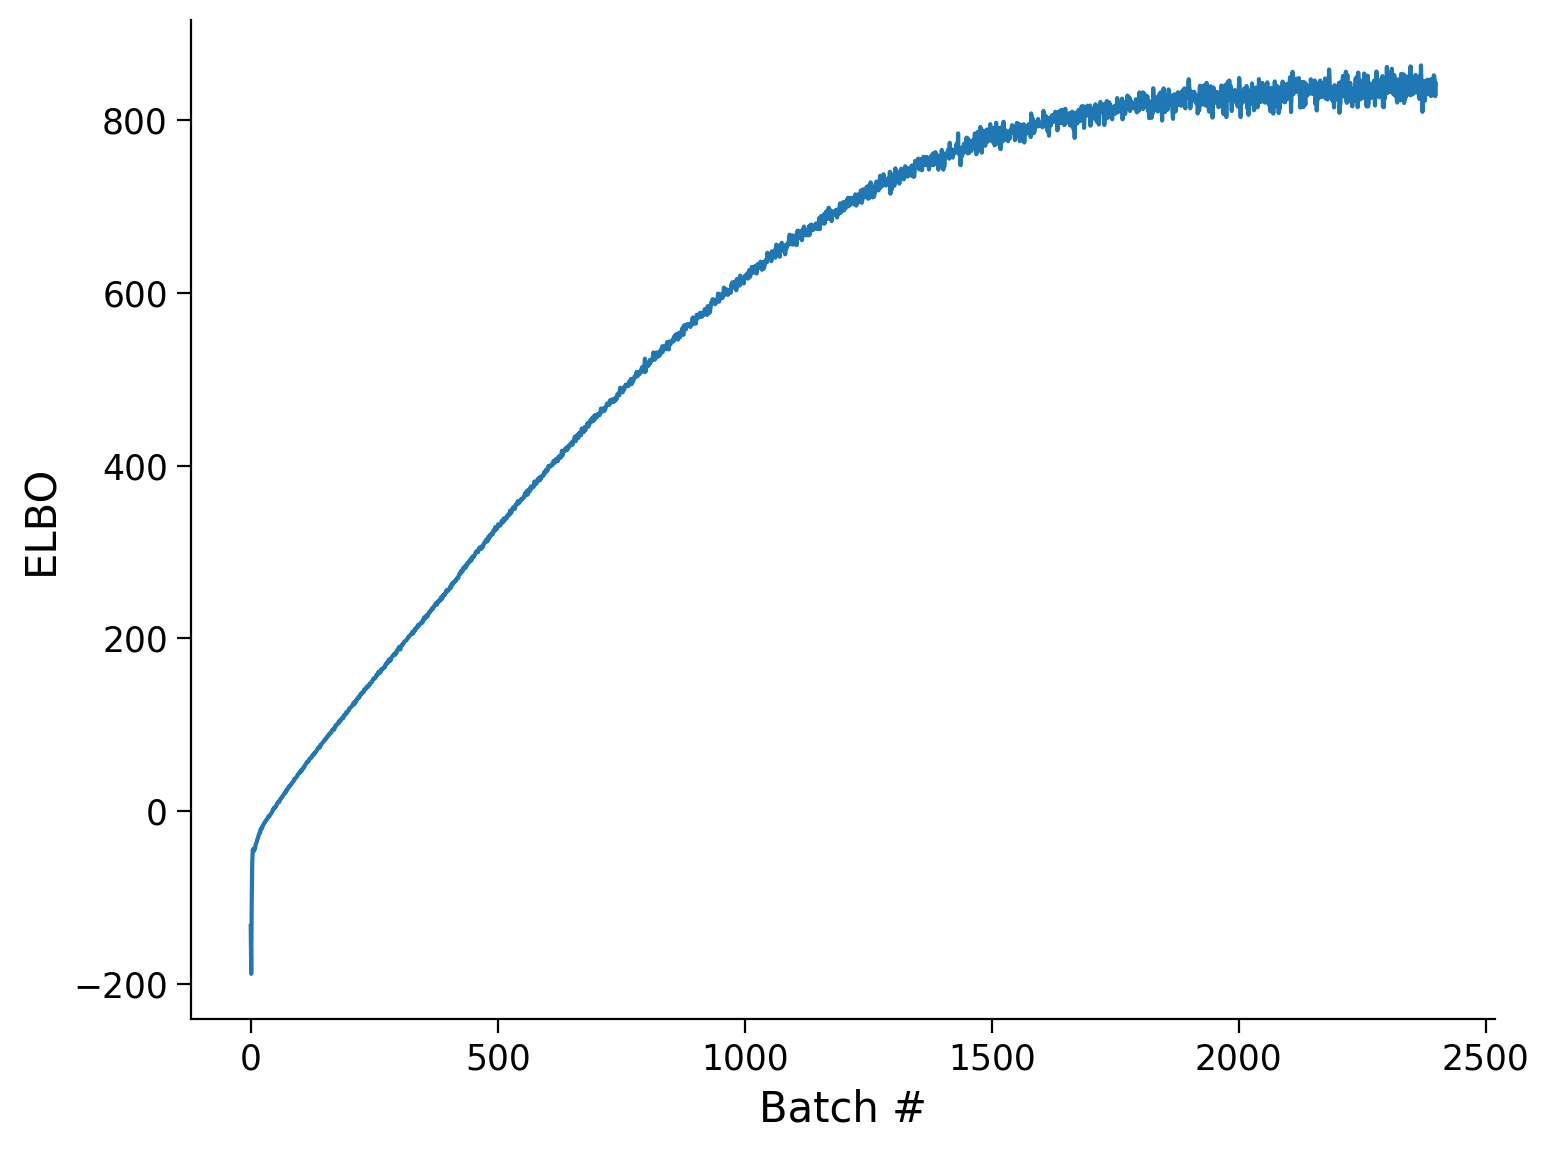

In [49]:
# @markdown Train a VAE for MNIST while watching the video. (Note: this VAE has a 2D latent space. If you are feeling ambitious, edit the code and modify the latent space dimensionality and see what happens.)
K_VAE = 2


class ConvVAE(nn.Module):
  """
  Convolutional Variational Autoencoder
  """
  def __init__(self, K, num_filters=32, filter_size=5):
    """
    Initialize parameters of ConvVAE

    Args:
      K: int
        Bottleneck dimensionality
      num_filters: int
        Number of filters [default: 32]
      filter_size: int
        Filter size [default: 5]

    Returns:
      Nothing
    """

    super(ConvVAE, self).__init__()

    # With padding=0, the number of pixels cut off from
    # each image dimension
    # is filter_size // 2. Double it to get the amount
    # of pixels lost in
    # width and height per Conv2D layer, or added back
    # in per
    # ConvTranspose2D layer.
    filter_reduction = 2 * (filter_size // 2)

    # After passing input through two Conv2d layers,
    # the shape will be
    # 'shape_after_conv'. This is also the shape that
    # will go into the first
    # deconvolution layer in the decoder
    self.shape_after_conv = (num_filters,
                              data_shape[1]-2*filter_reduction,
                              data_shape[2]-2*filter_reduction)
    flat_size_after_conv = self.shape_after_conv[0] \
        * self.shape_after_conv[1] \
        * self.shape_after_conv[2]

    # Define the recognition model (encoder or q) part
    self.q_bias = BiasLayer(data_shape)
    self.q_conv_1 = nn.Conv2d(data_shape[0], num_filters, 5)
    self.q_conv_2 = nn.Conv2d(num_filters, num_filters, 5)
    self.q_flatten = nn.Flatten()
    self.q_fc_phi = nn.Linear(flat_size_after_conv, K+1)

    # Define the generative model (decoder or p) part
    self.p_fc_upsample = nn.Linear(K, flat_size_after_conv)
    self.p_unflatten = nn.Unflatten(-1, self.shape_after_conv)
    self.p_deconv_1 = nn.ConvTranspose2d(num_filters, num_filters, 5)
    self.p_deconv_2 = nn.ConvTranspose2d(num_filters, data_shape[0], 5)
    self.p_bias = BiasLayer(data_shape)

    # Define a special extra parameter to learn
    # scalar sig_x for all pixels
    self.log_sig_x = nn.Parameter(torch.zeros(()))

  def infer(self, x):
    """
    Map (batch of) x to (batch of) phi which
    can then be passed to
    rsample to get z

    Args:
      x: torch.tensor
        Input features

    Returns:
      phi: np.ndarray
        Relative entropy
    """
    s = self.q_bias(x)
    s = F.relu(self.q_conv_1(s))
    s = F.relu(self.q_conv_2(s))
    flat_s = s.view(s.size()[0], -1)
    phi = self.q_fc_phi(flat_s)
    return phi

  def generate(self, zs):
    """
    Map [b,n,k] sized samples of z to
    [b,n,p] sized images

    Args:
      zs: np.ndarray
        Samples

    Returns:
      mu_zs: np.ndarray
        Mean of samples
    """
    # Note that for the purposes of passing
    # through the generator, we need
    # to reshape zs to be size [b*n,k]
    b, n, k = zs.size()
    s = zs.view(b*n, -1)
    s = F.relu(self.p_fc_upsample(s)).view((b*n,) + self.shape_after_conv)
    s = F.relu(self.p_deconv_1(s))
    s = self.p_deconv_2(s)
    s = self.p_bias(s)
    mu_xs = s.view(b, n, -1)
    return mu_xs

  def decode(self, zs):
    """
    Decoder

    Args:
      zs: np.ndarray
        Samples

    Returns:
      Generated images
    """
    # Included for compatability with conv-AE code
    return self.generate(zs.unsqueeze(0))

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.tensor
        Input image

    Returns:
      Generated images
    """
    # VAE.forward() is not used for training,
    # but we'll treat it like a
    # classic autoencoder by taking a single
    # sample of z ~ q
    phi = self.infer(x)
    zs = rsample(phi, 1)
    return self.generate(zs).view(x.size())

  def elbo(self, x, n=1):
    """
    Run input end to end through the VAE
    and compute the ELBO using n
    samples of z

    Args:
      x: torch.tensor
        Input image
      n: int
        Number of samples of z

    Returns:
      Difference between true and estimated KL divergence
    """
    phi = self.infer(x)
    zs = rsample(phi, n)
    mu_xs = self.generate(zs)
    return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)


def expected_z(phi):
  """
  Expected sample entropy

  Args:
    phi: list
      Relative entropy

  Returns:
    Expected sample entropy
  """
  return phi[:, :-1]


def rsample(phi, n_samples):
  """
  Sample z ~ q(z;phi)
  Output z is size [b,n_samples,K] given
  phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q,
  and phi[:,-1] is the log
  standard deviation

  Args:
    phi: list
      Relative entropy
    n_samples: int
      Number of samples

  Returns:
    Output z is size [b,n_samples,K] given
  phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q,
  and phi[:,-1] is the log
  standard deviation
  """
  b, kplus1 = phi.size()
  k = kplus1-1
  mu, sig = phi[:, :-1], phi[:,-1].exp()
  eps = torch.randn(b, n_samples, k, device=phi.device)
  return eps*sig.view(b,1,1) + mu.view(b,1,k)


def train_vae(vae, dataset, epochs=10, n_samples=1000):
  """
  Train VAE

  Args:
    vae: nn.module
      Model
    dataset: function
      Dataset
    epochs: int
      Epochs
    n_samples: int
      Number of samples

  Returns:
    elbo_vals: list
      List of values obtained from ELBO
  """
  opt = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=0)
  elbo_vals = []
  vae.to(DEVICE)
  vae.train()
  loader = DataLoader(dataset, batch_size=250, shuffle=True, pin_memory=True)
  for epoch in trange(epochs, desc='Epochs'):
    for im, _ in tqdm(loader, total=len(dataset) // 250, desc='Batches', leave=False):
      im = im.to(DEVICE)
      opt.zero_grad()
      loss = -vae.elbo(im)
      loss.backward()
      opt.step()

      elbo_vals.append(-loss.item())
  vae.to('cpu')
  vae.eval()
  return elbo_vals


trained_conv_VarAE = ConvVAE(K=K_VAE)
elbo_vals = train_vae(trained_conv_VarAE, train_set, n_samples=10000)

print(f'Learned sigma_x is {torch.exp(trained_conv_VarAE.log_sig_x)}')

# Uncomment below if you'd like to see the the training
# curve of the evaluated ELBO loss function
# ELBO is the loss function used to train VAEs
# (see lecture!)
plt.figure()
plt.plot(elbo_vals)
plt.xlabel('Batch #')
plt.ylabel('ELBO')
plt.show()

ELBO is the loss function used to train VAEs - note that we are maximizing ELBO (higher ELBO is better). We implement this in PyTorch code set up to minimize things by making the loss equal to negative ELBO.

## Section 4.1: Components of a VAE

*Recognition models and density networks*


Variational AutoEncoders (VAEs) are a lot like the classic AutoEncoders (AEs), but where we explicitly think about probability distributions. In the language of VAEs, the __encoder__ is replaced with a __recognition model__, and the __decoder__ is replaced with a __density network__.

Where in a classic autoencoder the encoder maps from images to a single hidden vector,

\begin{equation}
\mathbf{x} \overset{\text{AE}}{\longrightarrow} \mathbf{h} \, ,
\end{equation}

in a VAE we would say that a recognition model maps from inputs to entire __distributions__ over hidden vectors,

\begin{equation}
\mathbf{x} \overset{\text{VAE}}{\longrightarrow} q_{\mathbf{w_e}}(\mathbf{z}) \, ,
\end{equation}

which we will then sample from. Here $\mathbf{w_e}$ refers to the weights of the recognition model, which parametarize our distribution generating network. We'll say more in a moment about what kind of distribution $q_{\mathbf{w_e}}(\mathbf{z})$ is.
Part of what makes VAEs work is that the loss function will require good reconstructions of the input not just for a single $\mathbf{z}$, but _on average_ from samples of $\mathbf{z} \sim q_{\mathbf{w_e}}(\mathbf{z})$.

In the classic autoencoder, we had a decoder which maps from hidden vectors to reconstructions of the input:

\begin{equation}
\mathbf{h} \overset{\text{AE}}{\longrightarrow} \mathbf{x'} \, .
\end{equation}

In a density network, reconstructions are expressed in terms of a distribution:

\begin{equation}
\mathbf{z} \overset{\text{VAE}}{\longrightarrow} p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})
\end{equation}

where, as above, $p_{\mathbf{w_d}}(\mathbf{x}|\mathbf{z})$ is defined by mapping $\mathbf{z}$ through a density network then treating the resulting $f(\mathbf{z};\mathbf{w_d})$ as the mean of a (Gaussian) distribution over $\mathbf{x}$. Similarly, our reconstruction distribution is parametarized by the weights of the density network.

## Section 4.2: Generating novel images from the decoder

If we isolate the decoder part of the AutoEncoder, what we have is a neural network that takes as input a vector of size $K$ and produces as output an image that looks something like our training data. Recall that in our earlier notation, we had an input $\mathbf{x}$ that was mapped to a low-dimensional hidden representation $\mathbf{h}$ which was then decoded into a reconstruction of the input, $\mathbf{x'}$:

\begin{equation}
\mathbf{x} \overset{\text{encode}}{\longrightarrow} \mathbf{h} \overset{\text{decode}}{\longrightarrow} \mathbf{x'}\, .
\end{equation}

Partly as a matter of convention, and partly to distinguish where we are going next from the previous section, we're going to introduce a new variable, $\mathbf{z} \in \mathbb{R}^K$, which will take the place of $\mathbf{h}$. The key difference is that while $\mathbf{h}$ is produced by the encoder for a particular $\mathbf{x}$, $\mathbf{z}$ will be drawn out of thin air from a prior of our choosing:

\begin{equation}
\mathbf{z} \sim p(\mathbf{z})\\ \mathbf{z} \overset{\text{decode}}{\longrightarrow} \mathbf{x}\, .
\end{equation}

(Note that it is also common convention to drop the "prime" on $\mathbf{x}$ when it is no longer being thought of as a "reconstruction").

### Coding Exercise 4.2: Generating images

Complete the code below to generate some images from the VAE that we trained above.

Random seed 2021 has been set.


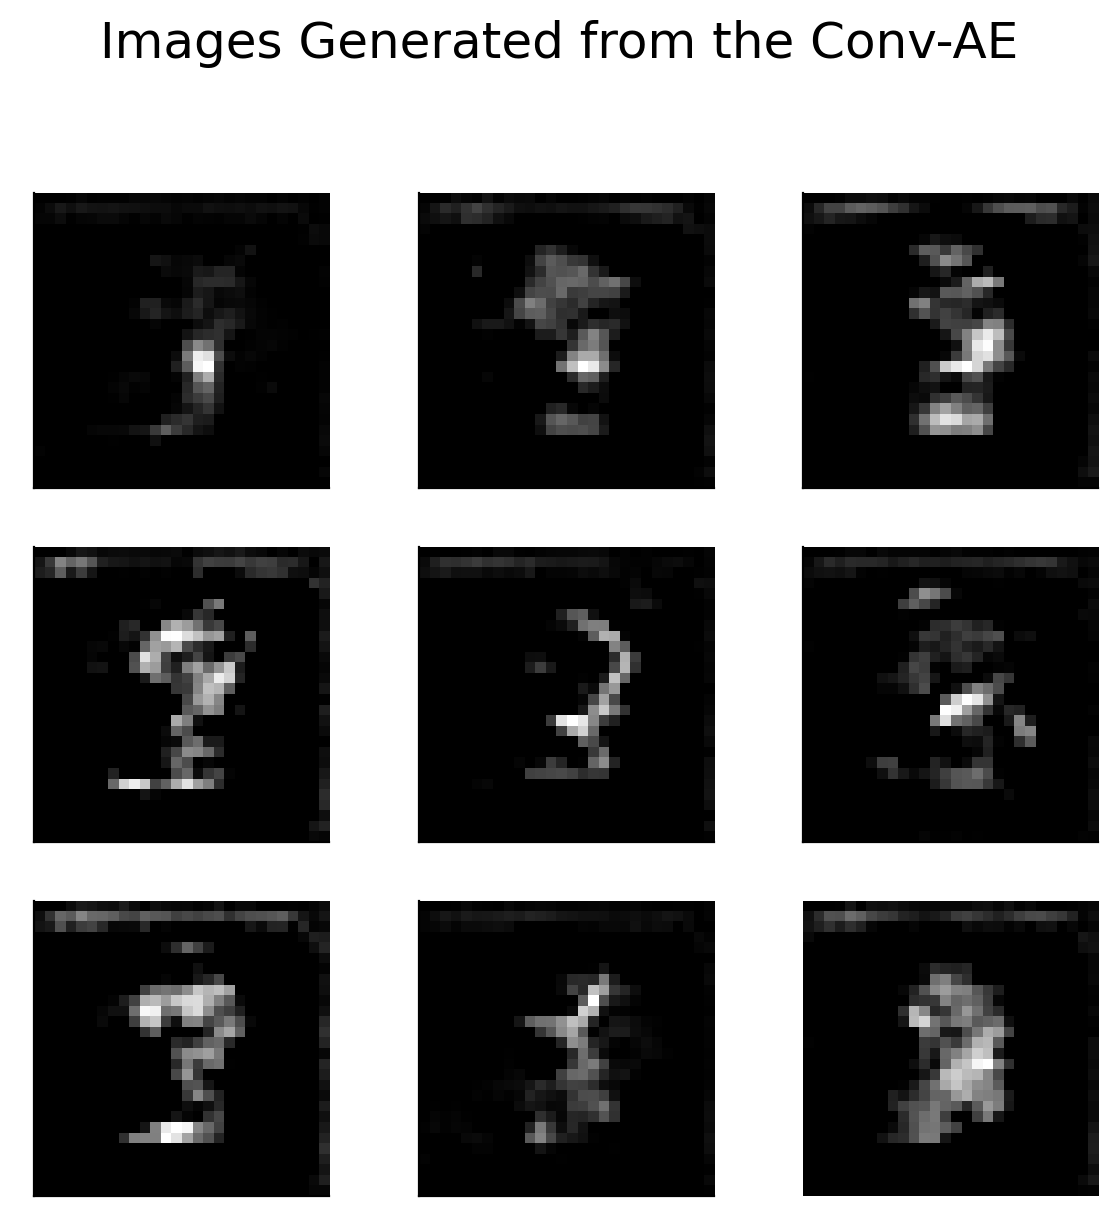

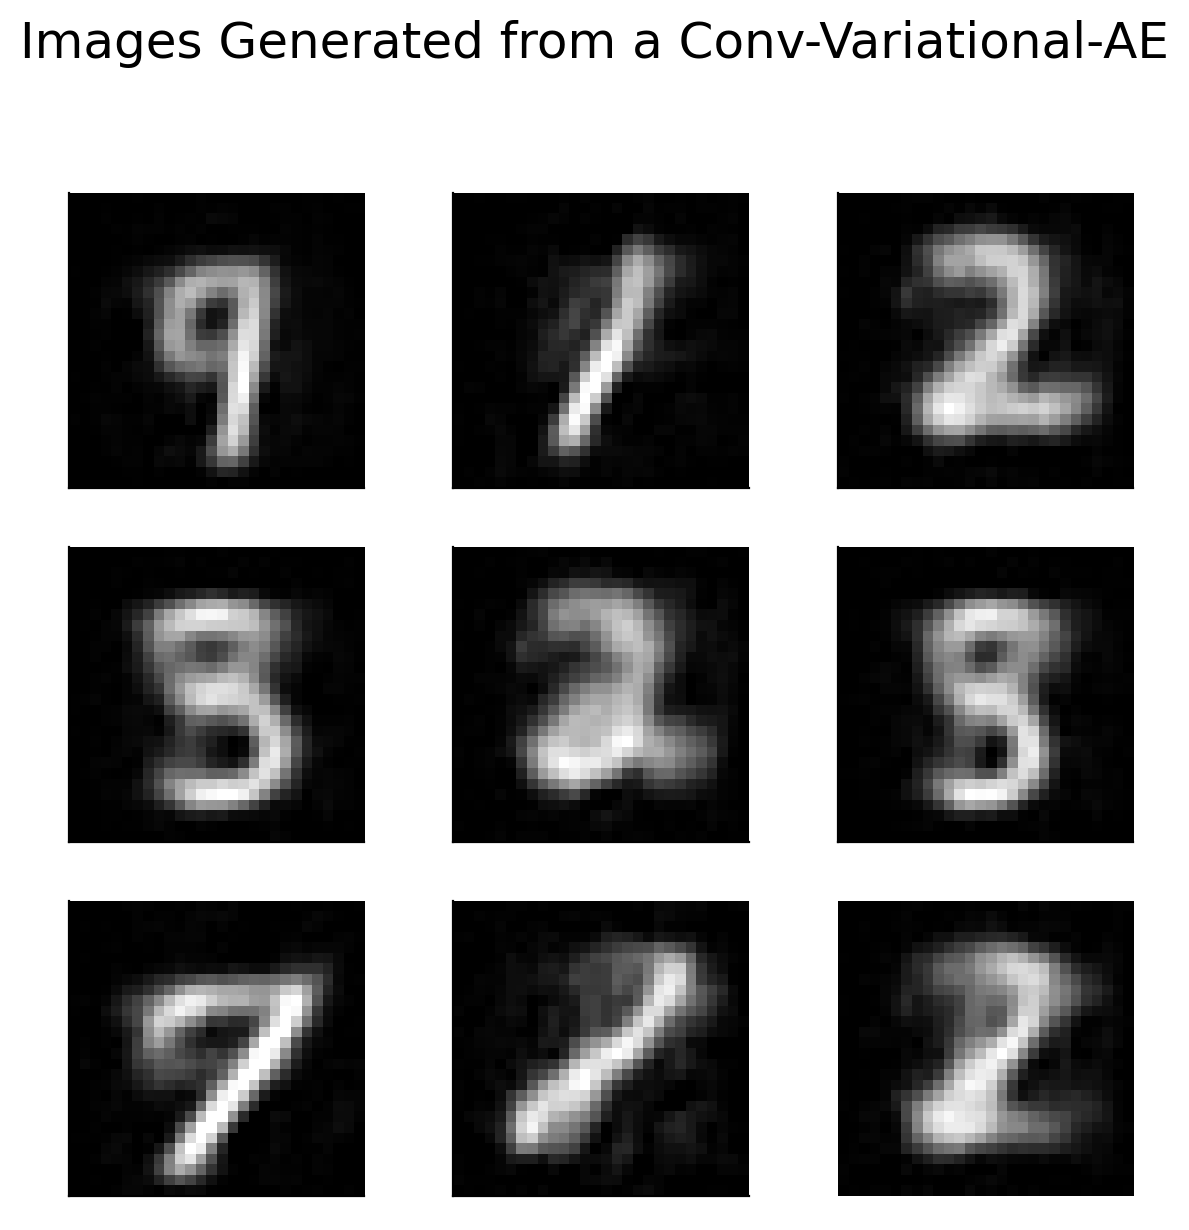

In [50]:
def generate_images(autoencoder, K, n_images=1):
  """
  Generate n_images 'new' images from the decoder part of the given
  autoencoder.

  Args:
    autoencoder: nn.module
      Autoencoder model
    K: int
      Bottleneck dimension
    n_images: int
      Number of images

  Returns:
    x: torch.tensor
      (n_images, channels, height, width) tensor of images
  """
  # Concatenate tuples to get (n_images, channels, height, width)
  output_shape = (n_images,) + data_shape
  with torch.no_grad():
    # Sample z from a unit gaussian, pass through autoencoder.decode()
    z = torch.randn(n_images, K)
    x = autoencoder.decode(z)

    return x.reshape(output_shape)

set_seed(seed=SEED)
## Uncomment to test your solution
images = generate_images(trained_conv_AE, K, n_images=9)
plot_images(images, plt_title='Images Generated from the Conv-AE')
images = generate_images(trained_conv_VarAE, K_VAE, n_images=9)
plot_images(images, plt_title='Images Generated from a Conv-Variational-AE')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_775a81ae.py)



####  Submit your feedback


In [51]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Generating_images_Exercise")

### Think! 4.2: AutoEncoders vs. Variational AutoEncoders

Compare the images generated by the AutoEncoder to the images generated by the Variational AutoEncoder. You can run the code a few times to see a variety of examples.

Does one set look more like the training set (handwritten digits) than the other? What is driving this difference?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials/W2D4_GenerativeModels/solutions/W2D4_Tutorial1_Solution_0e74baf7.py)



####  Submit your feedback


In [52]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_AutoEncoders_vs_Variational_AutoEncoders_Discussion")

---
# Section 5: State of the art VAEs and Wrap-up

##  Video 5: State-Of-The-Art VAEs


In [53]:
# @title Video 5: State-Of-The-Art VAEs
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'PXBl3KwRfh4'), ('Bilibili', 'BV1hg411M7KY')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

##  Submit your feedback


In [54]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_SOTA_VAEs_and_WrapUp_Video")

---
# Summary

Through this tutorial, we have learned
- What a generative model is and why we are interested in them.
- How latent variable models relate to generative models with the example of pPCA.
- What a basic AutoEncoder is and how they relate to other latent variable models.
- The basics of Variational AutoEncoders and how they function as generative models.
- An introduction to the broad applications of VAEs.